In [1]:
import pandas as pd
import os 
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from moviepy.editor import VideoFileClip
from matplotlib.animation import FuncAnimation
import cv2
from scipy import stats
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

In [151]:
# functions
def adjust_brightness_contrast(frame, brightness=0, contrast=0):
    frame_float = frame.astype(np.float32)
    frame_float += brightness
    frame_float = frame_float * (contrast / 127 + 1) - contrast
    frame_float = np.clip(frame_float, 0, 255)
    frame_adjusted = frame_float.astype(np.uint8)
    return frame_adjusted



def tracking(video_path):
    output_path = video_path.replace('recording', 'marked')
    df_path = video_path.replace('recording.mp4', 'coords.csv')
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    target_color_rgb = (220,220,220)
    target_color_hsv = cv2.cvtColor(np.uint8([[target_color_rgb]]), cv2.COLOR_RGB2HSV)[0][0]
    hsv_range = 30  # Adjust this range if needed
    lower_target_color = np.array([0, 0, target_color_hsv[2] - hsv_range])  # [H, 0, V-range]
    upper_target_color = np.array([180, 50, target_color_hsv[2] + hsv_range])  # [H, low saturation, V+range]
    coordinates = []
    brightness = -50
    contrast = 100

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        timestamp = frame_number / fps
        
        adjusted_frame = adjust_brightness_contrast(frame, brightness, contrast)
        hsv_frame = cv2.cvtColor(adjusted_frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_frame, lower_target_color, upper_target_color)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) > 20 and cv2.contourArea(contour) < 50:
                x, y, w, h = cv2.boundingRect(contour)
                coordinates.append((timestamp, x, y, w, h))
                center_x = x + w // 2
                center_y = y + h // 2
                cv2.circle(adjusted_frame, (center_x, center_y), 5, (0, 255, 0), -1)
                label = f"({center_x}, {center_y})"
                cv2.putText(adjusted_frame, label, (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        out.write(adjusted_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    df = pd.DataFrame(coordinates, columns=['Time', 'X', 'Y', 'Width', 'Height'])
    df.to_csv(df_path, index=False)

def fourier(time, act, phase):
    time_step = np.mean(np.diff(time))
    fft_result = np.fft.fft(act)
    frequencies = np.fft.fftfreq(len(act), d=time_step)
    power_spectrum = np.abs(fft_result)
    plt.figure(figsize=(8, 6))
    plt.plot(frequencies[:len(frequencies) // 2], power_spectrum[:len(power_spectrum) // 2], color='black')
    plt.title(phase)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.xlim(0, 0.5)
    plt.ylim(0, 200000)
    
    df = pd.DataFrame({
    'Frequency': frequencies,
    'Power Spectrum': power_spectrum
    })
    df.to_csv(path + f'/{phase} fft result.csv', index=False)

    dominant_frequency = None
    dominant_power = 0
    
    for freq, power in zip(frequencies, power_spectrum):
        if freq >= 0.01 and power > dominant_power:
            dominant_frequency = freq
            dominant_power = power
    
    if dominant_frequency is not None:
        plt.annotate(f'{dominant_frequency:.4f} Hz',
                     xy=(dominant_frequency, dominant_power),
                     xytext=(dominant_frequency, dominant_power * 1.1),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     horizontalalignment='center')
    plt.savefig(f"{path}/{phase}.png", dpi=300)
    return dominant_frequency


def phase_lock_angle(data1,data2):
    fp_time = data1['Time'].values
    fp_signal = data1['filtered Delta F/F(ZScore)'].values
    hm_time = data2['Time'].values
    hm_signal = data2['X'].values
    f1 = interp1d(fp_time, fp_signal, kind='linear')
    f2 = interp1d(hm_time, hm_signal, kind='linear')

    common_time = np.linspace(max(fp_time.min(), hm_time.min()), min(fp_time.max(), hm_time.max()), num=1000)

    signal1_interp = f1(common_time)
    signal2_interp = f2(common_time)
    hilbert1 = hilbert(signal1_interp)
    phase1 = np.angle(hilbert1)

    hilbert2 = hilbert(signal2_interp)
    phase2 = np.angle(hilbert2)
    plv = np.abs(np.mean(np.exp(1j * (phase1 - phase2))))

    return plv

def combine_plot(file, fp, hm, phase):
    fig, ax1 = plt.subplots()
    ax1.plot(fp['Time'], fp['filtered Delta F/F(ZScore)'], label='Photometry signal', color = 'red',linewidth = 1)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('dF/F', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx()
    ax2.plot(hm['Time'], hm['X'], label='Head motion', color = 'blue',linewidth = 1)
    ax2.set_ylabel('Pixel', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.title(os.path.basename(file) + phase)
    plt.savefig(file + f'/photometry and motion {phase}.png', dpi = 300)
    plt.clf()
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs 
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def filter_signal(file):
    fs = 1000.0 
    cutoff = 1.0
    order = 4  
    df = pd.read_csv(file)
    t = df['Time'] - df['Time'][0]
    signal = df['Delta F/F(ZScore)']
    df['filtered Delta F/F(ZScore)'] = lowpass_filter(signal, cutoff, fs, order)
    df.to_csv(file, index = False)
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal, label='Original Signal',linewidth = 1, color = 'red')
    plt.plot(t, df['filtered Delta F/F(ZScore)'], label='Filtered Signal', linewidth = 1, color = 'black')
    plt.xlabel('Time (s)')
    plt.ylabel('Delta F/F(ZScore)')
    plt.legend()
    plt.grid()
    plt.savefig(file.replace('.csv',' filtered.png'),dpi = 300)

In [26]:
folder = '/Users/issacwei/Desktop/LAB/Lee/data/photometry/083024 left/'

In [152]:
file_list = [x for x in glob.glob(folder+'*') if 'tilt' not in x and 'vibration' not in x]
awake = [x for x in file_list if 'awake' in x]
pitch_rocking = [x for x in file_list if 'awake' not in x and 'pitch' in x]
roll_rocking = [x for x in file_list if 'awake' not in x and 'roll' in x]

In [160]:
def tracking_test(video_path):
    output_path = video_path.replace('recording', 'tracking_test_output')
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    target_color_rgb = (220,220,220)
    target_color_hsv = cv2.cvtColor(np.uint8([[target_color_rgb]]), cv2.COLOR_RGB2HSV)[0][0]
    hsv_range = 30  # Adjust this range if needed
    lower_target_color = np.array([0, 0, target_color_hsv[2] - hsv_range])  # [H, 0, V-range]
    upper_target_color = np.array([180, 50, target_color_hsv[2] + hsv_range])  # [H, low saturation, V+range]
    coordinates = []
    brightness = -50
    contrast = 100
    
    # Set the start and end frames for the 10-second preview
    start_time = 100  # seconds
    end_time = 110    # seconds
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)  # Start from 100 seconds

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
            break
        
        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        timestamp = frame_number / fps
        
        adjusted_frame = adjust_brightness_contrast(frame, brightness, contrast)
        hsv_frame = cv2.cvtColor(adjusted_frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_frame, lower_target_color, upper_target_color)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) > 20 and cv2.contourArea(contour) < 50:
                x, y, w, h = cv2.boundingRect(contour)
                coordinates.append((timestamp, x, y, w, h))
                center_x = x + w // 2
                center_y = y + h // 2
                cv2.circle(adjusted_frame, (center_x, center_y), 5, (0, 255, 0), -1)
                label = f"({center_x}, {center_y})"
                cv2.putText(adjusted_frame, label, (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        out.write(adjusted_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [161]:
pitch_rocking[0]

'/Users/issacwei/Desktop/LAB/Lee/data/photometry/083024 left/WT-L2-pitch-083024'

In [162]:
tracking_test(pitch_rocking[0] + '/recording.mp4')

# Tracking motion and export data

Now processing WT-L2-pitch-083024
Now processing WT-L3-pitch-083024
Now processing WT-L1-pitch-083024


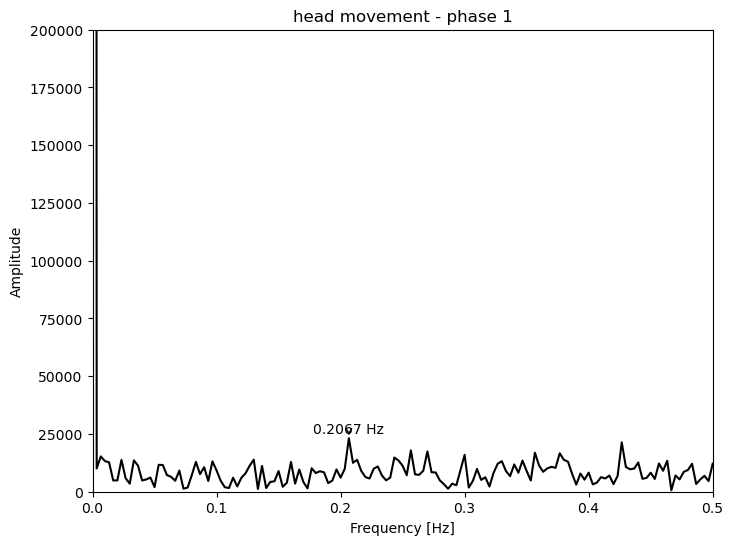

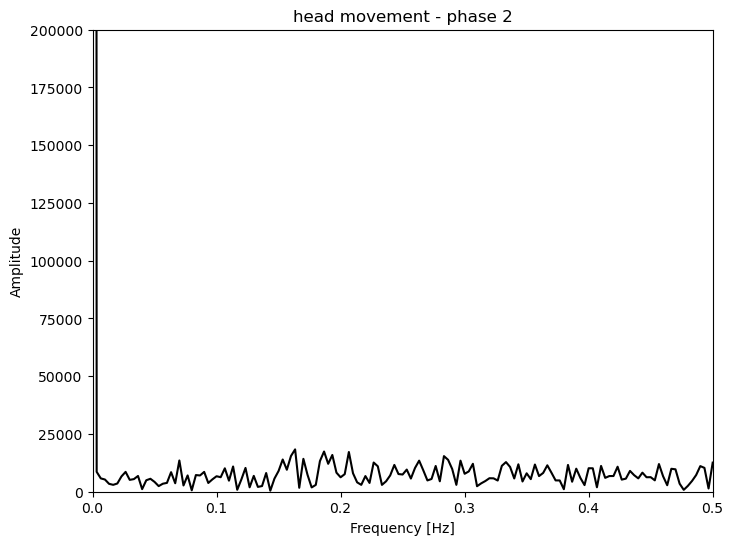

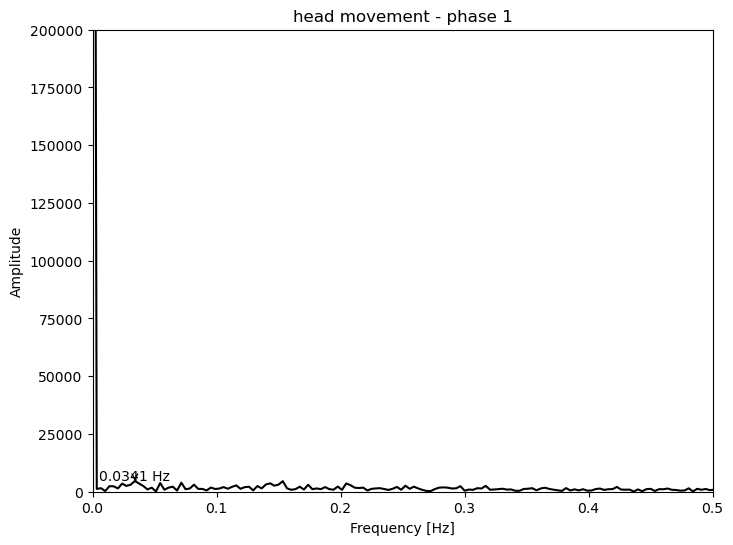

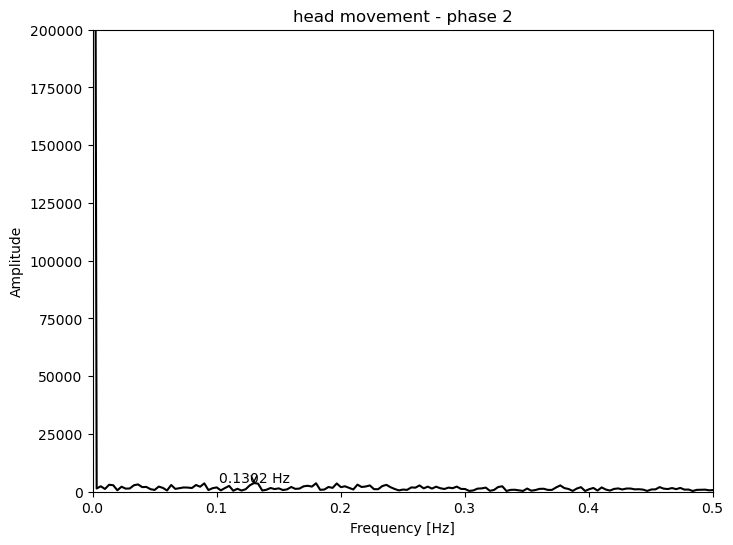

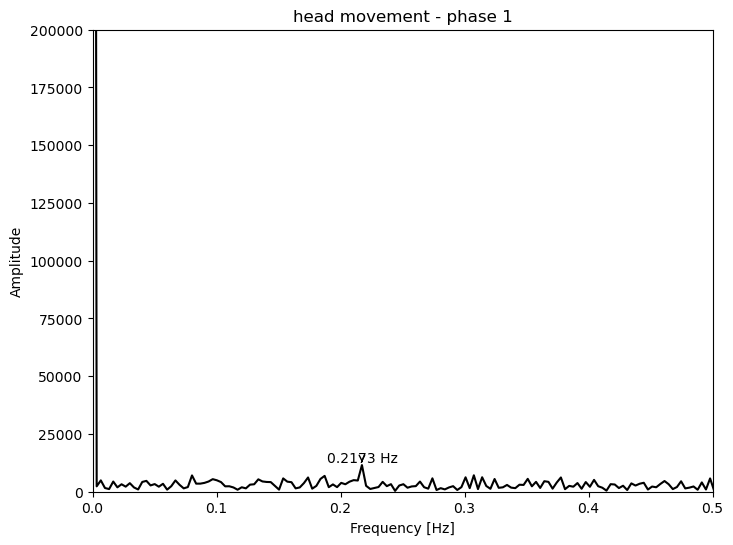

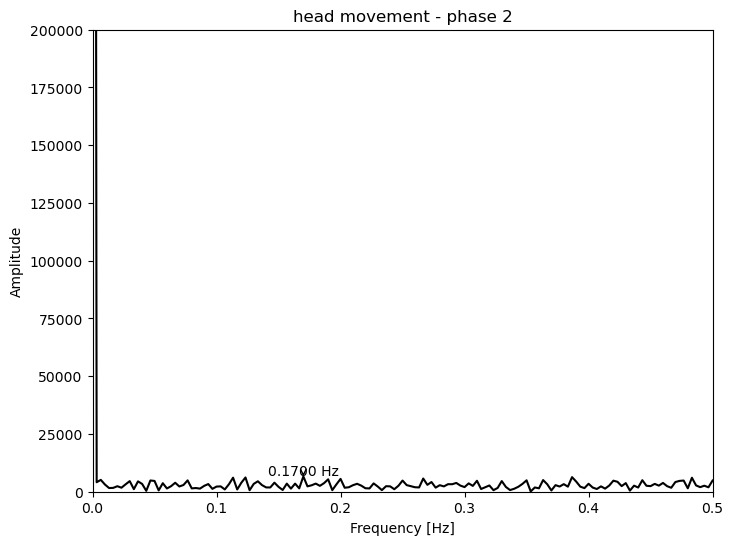

In [163]:
# tracking and fourier transformation for all files
for item in pitch_rocking:
    print(f'Now processing {os.path.basename(item)}')
    path = item
    tracking(path + '/recording.mp4')
    df = pd.read_csv(path + '/coords.csv')
    df = df[(df['X']>250) & (df['X']<420)]
    df = df[df['Y']>150]
    df_1 = df[(60 < df['Time']) & (df['Time'] < 360)]
    df_2 = df[(360 < df['Time']) & (df['Time'] < 660)]
    time_1 = np.array(df_1['Time'])
    time_2 = np.array(df_2['Time'])
    act_1 = np.array(df_1['X'])
    act_2 = np.array(df_2['X'])

    dominant_df = pd.DataFrame({'head movement - phase 1': [fourier(time_1, act_1,'head movement - phase 1')],
        'head movement - phase 2': [fourier(time_2, act_2,'head movement - phase 2')]})
    dominant_df.to_csv(path + '/head movement dominant freq.csv', index=False) 

# Fourier analysis for motion, compare to photometry signal

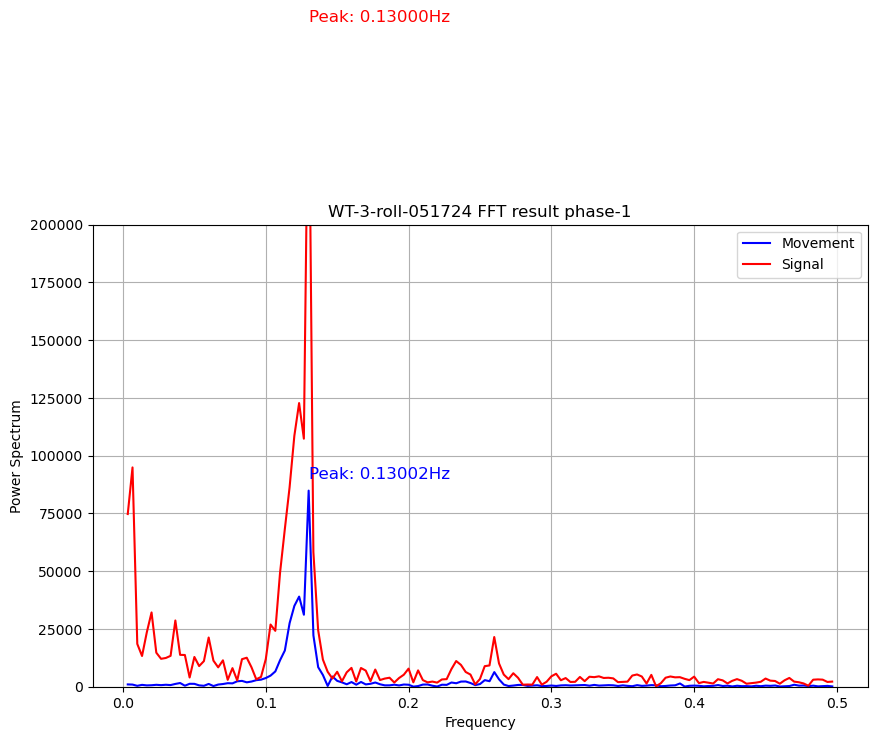

<Figure size 640x480 with 0 Axes>

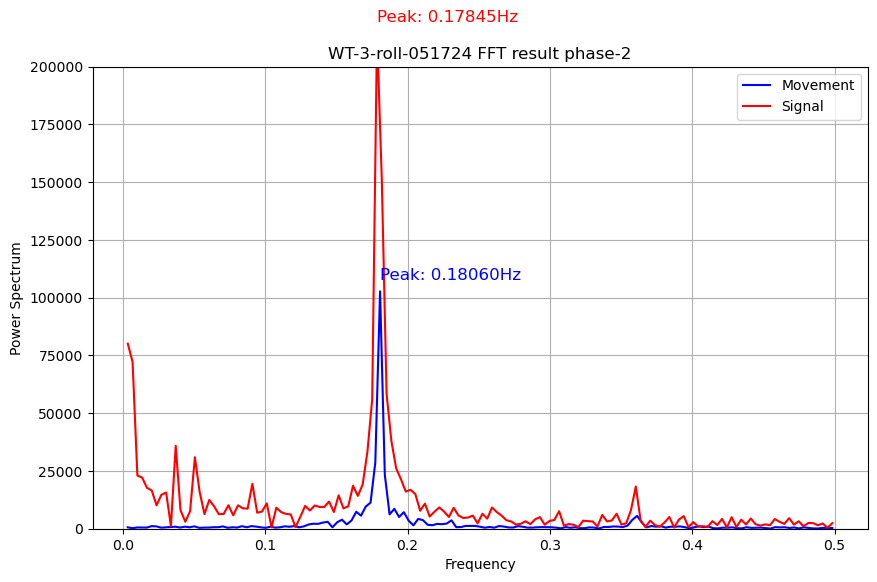

<Figure size 640x480 with 0 Axes>

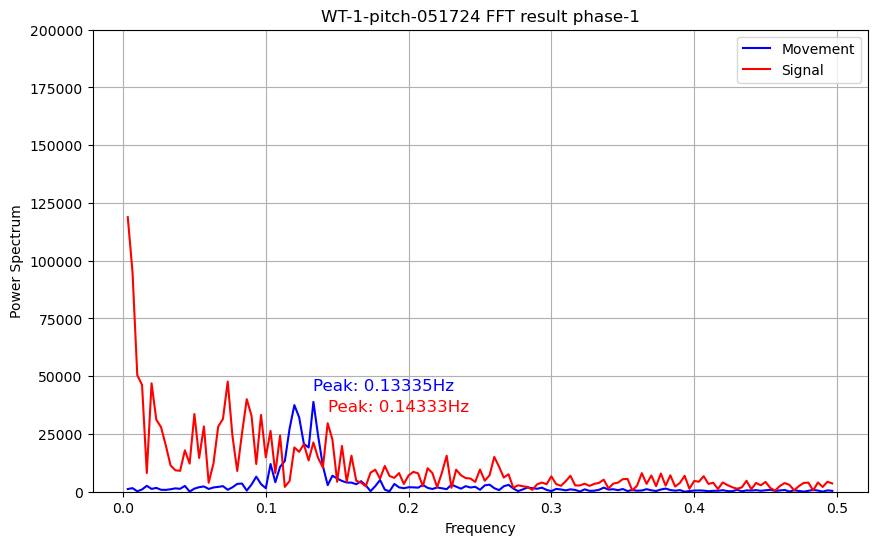

<Figure size 640x480 with 0 Axes>

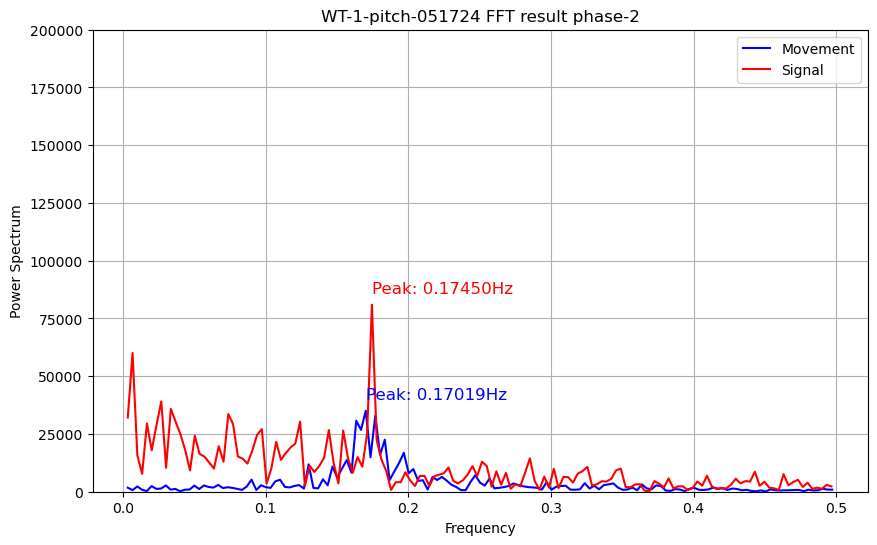

<Figure size 640x480 with 0 Axes>

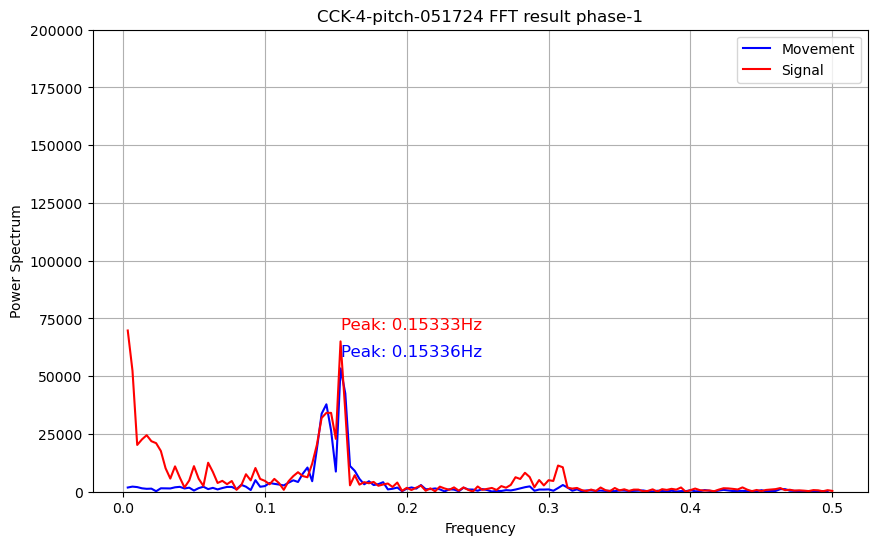

<Figure size 640x480 with 0 Axes>

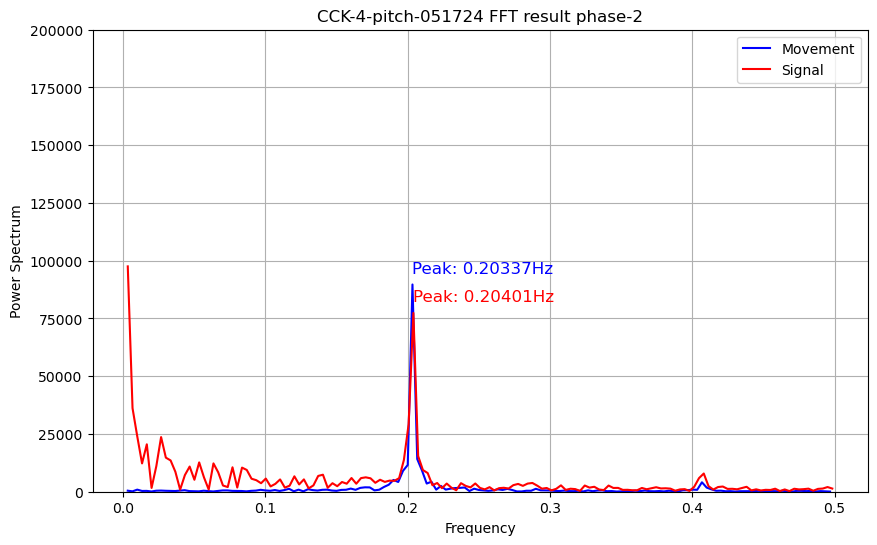

<Figure size 640x480 with 0 Axes>

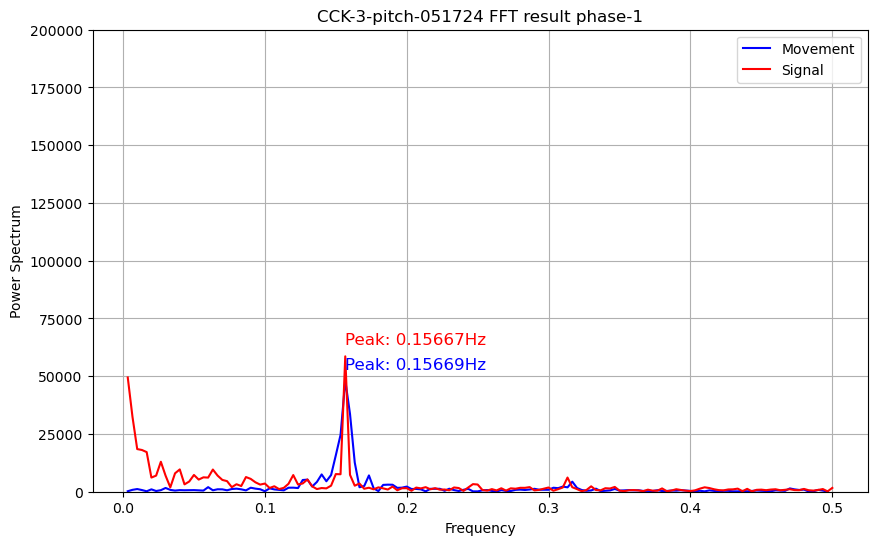

<Figure size 640x480 with 0 Axes>

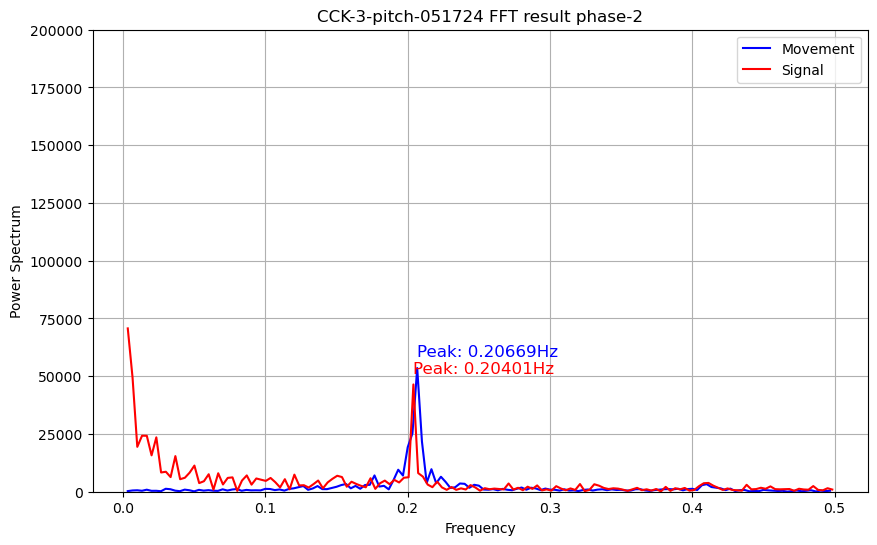

<Figure size 640x480 with 0 Axes>

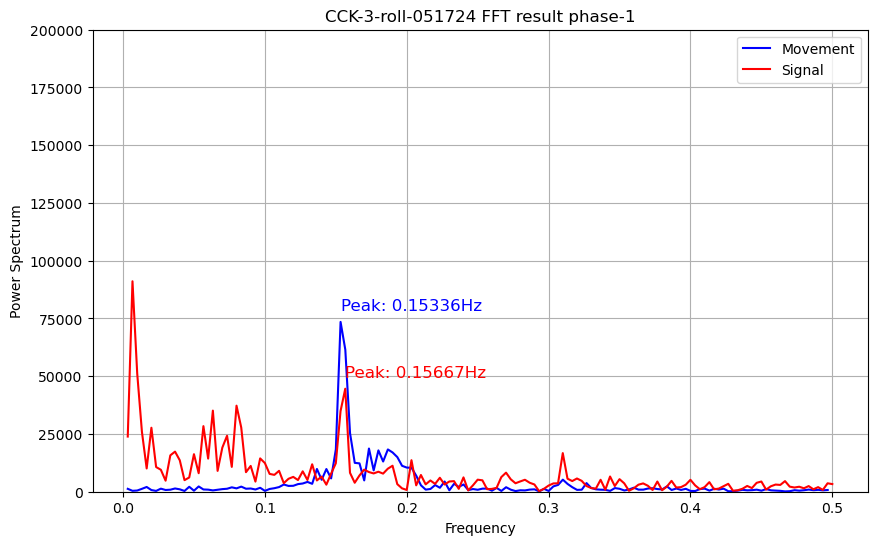

<Figure size 640x480 with 0 Axes>

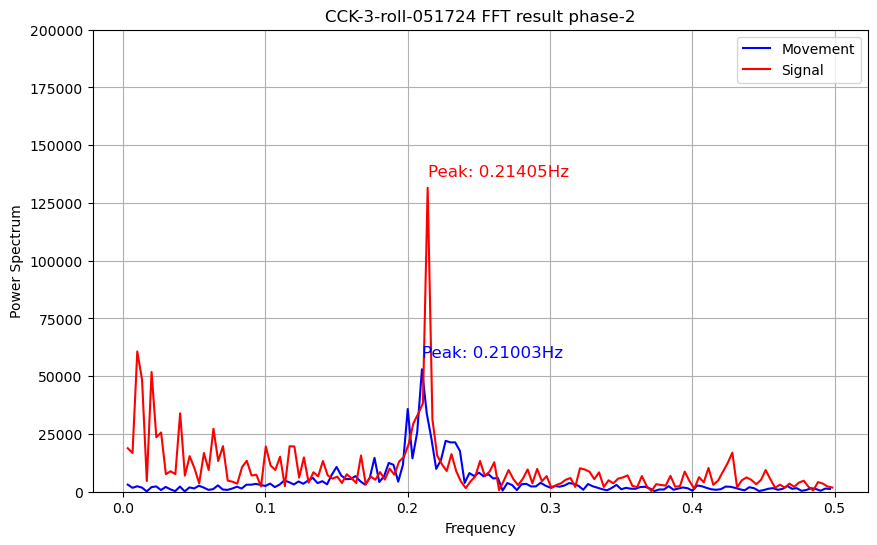

<Figure size 640x480 with 0 Axes>

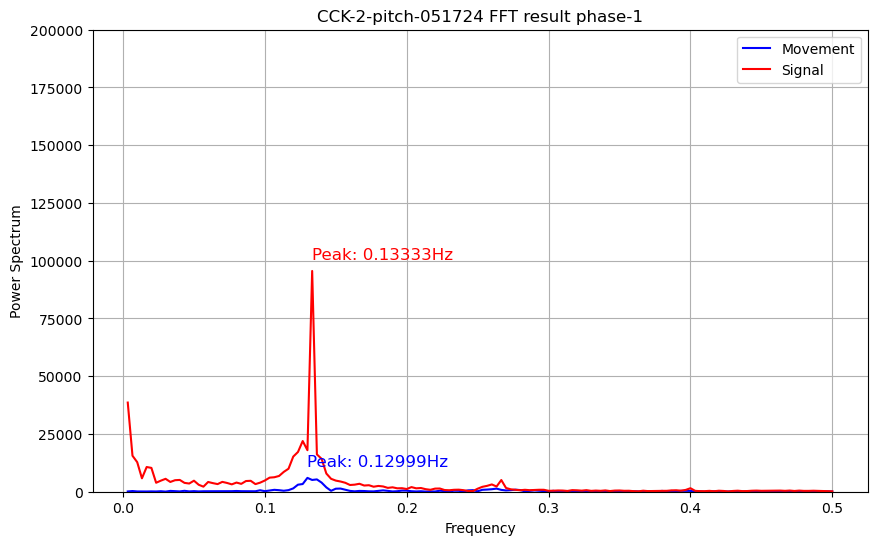

<Figure size 640x480 with 0 Axes>

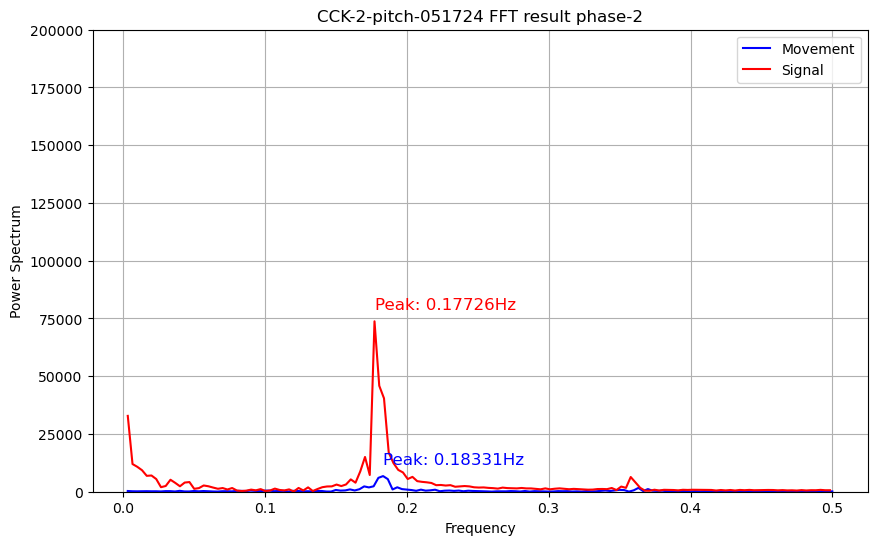

<Figure size 640x480 with 0 Axes>

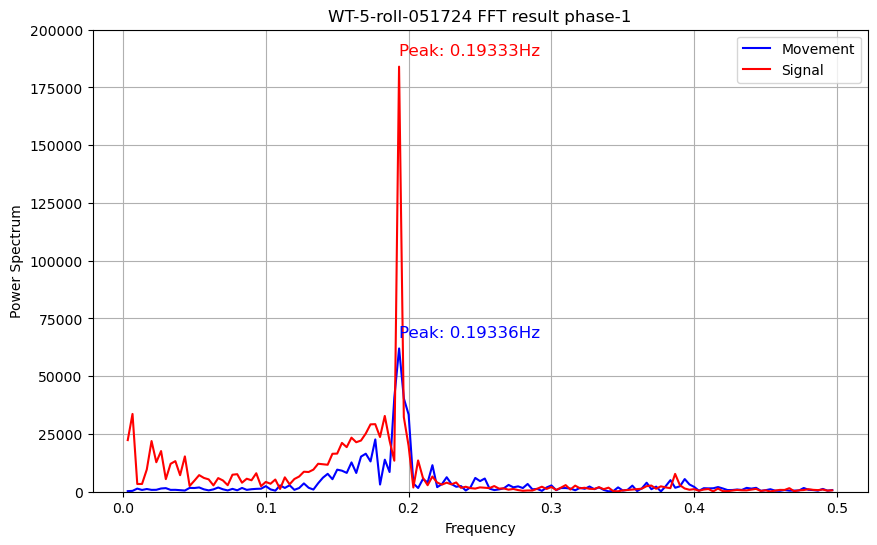

<Figure size 640x480 with 0 Axes>

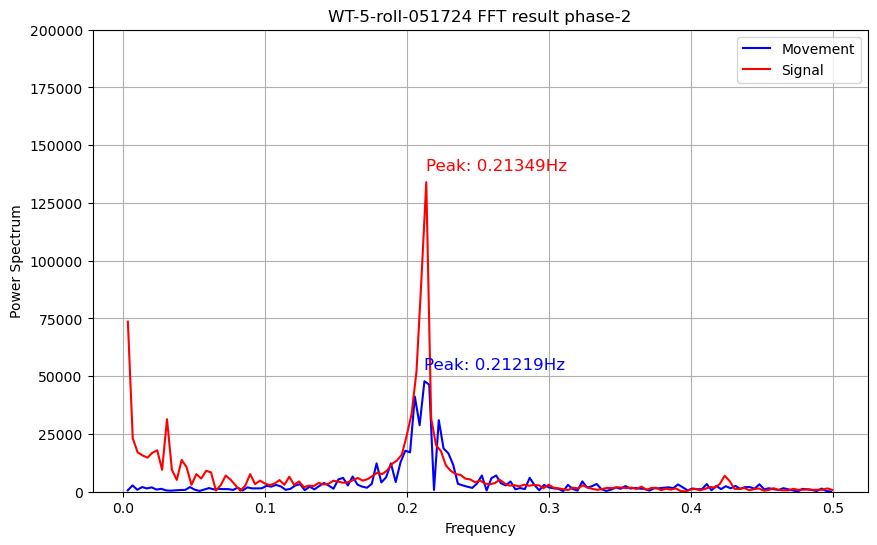

<Figure size 640x480 with 0 Axes>

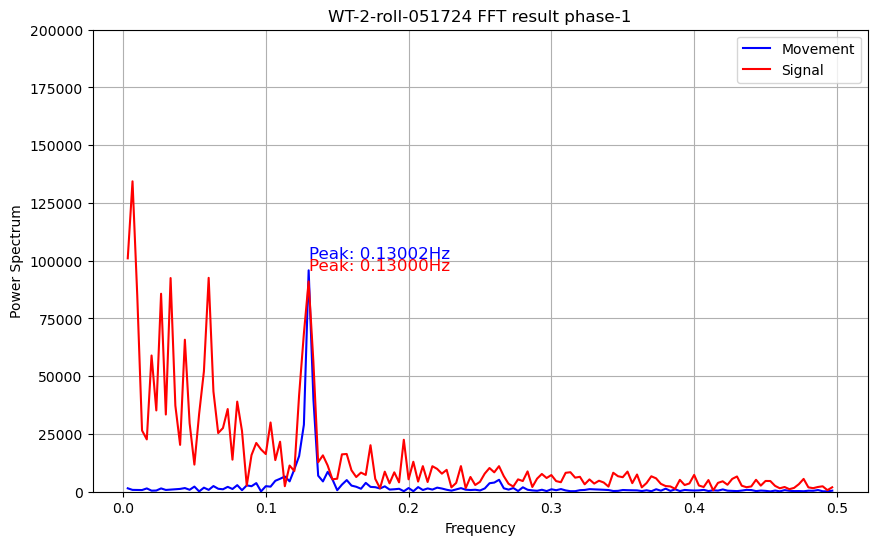

<Figure size 640x480 with 0 Axes>

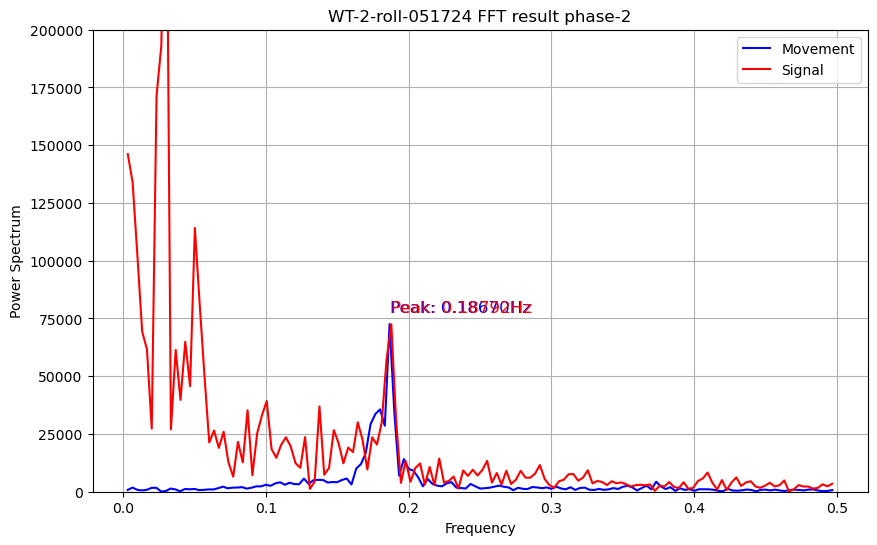

<Figure size 640x480 with 0 Axes>

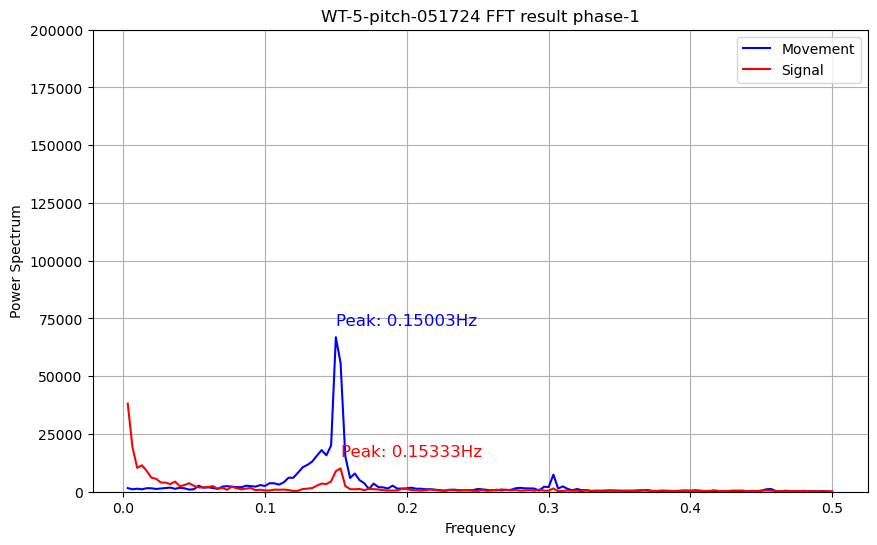

<Figure size 640x480 with 0 Axes>

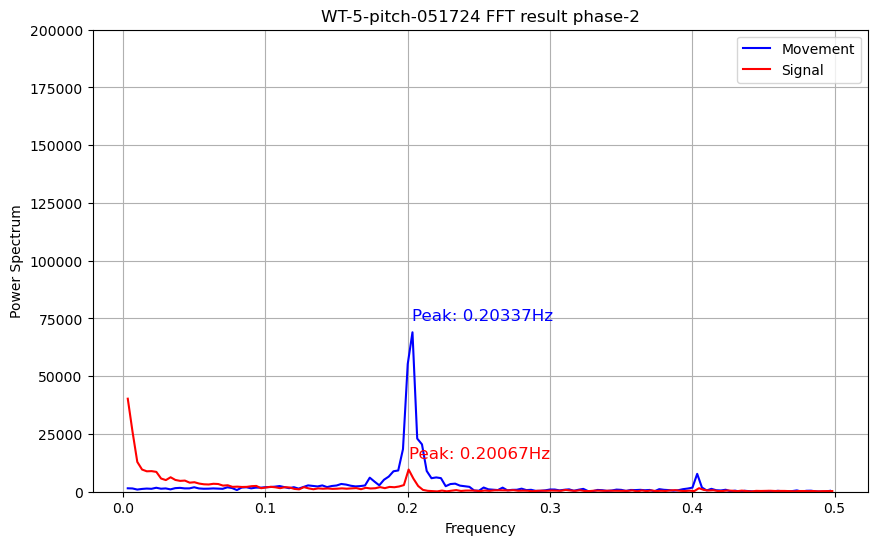

<Figure size 640x480 with 0 Axes>

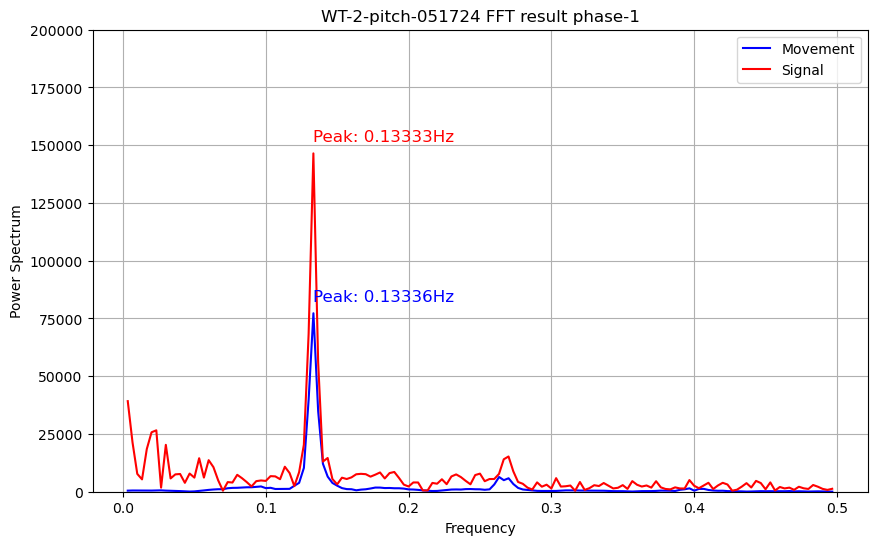

<Figure size 640x480 with 0 Axes>

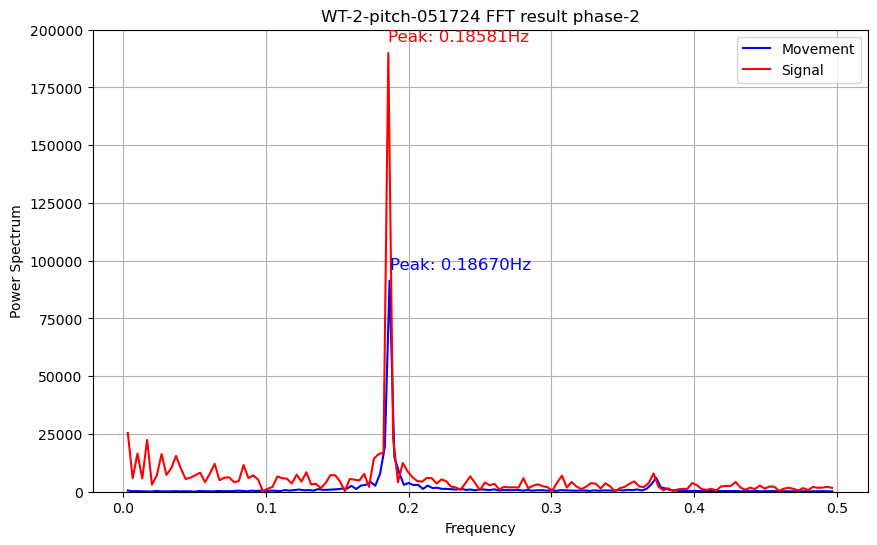

<Figure size 640x480 with 0 Axes>

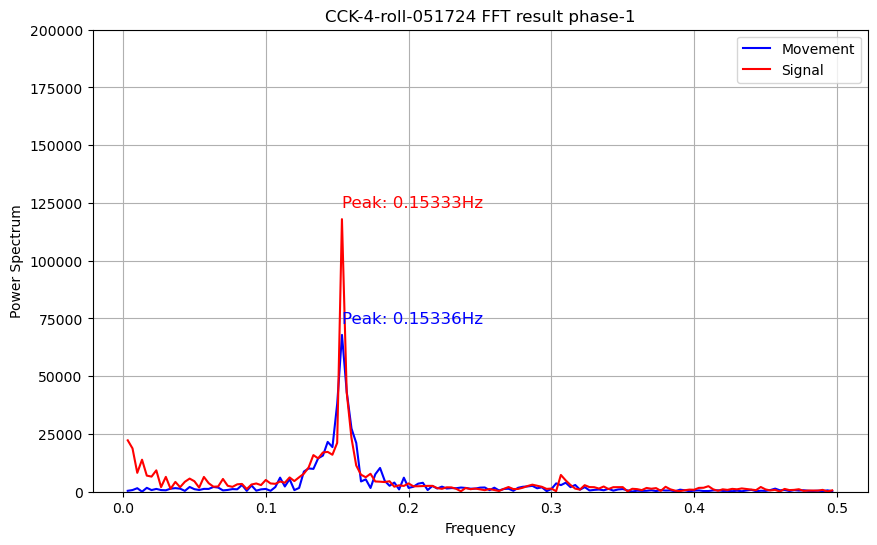

<Figure size 640x480 with 0 Axes>

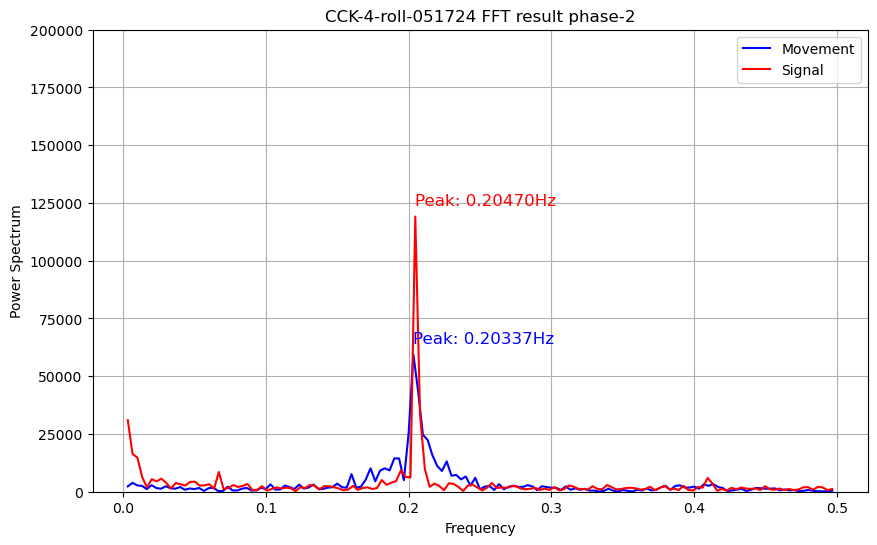

<Figure size 640x480 with 0 Axes>

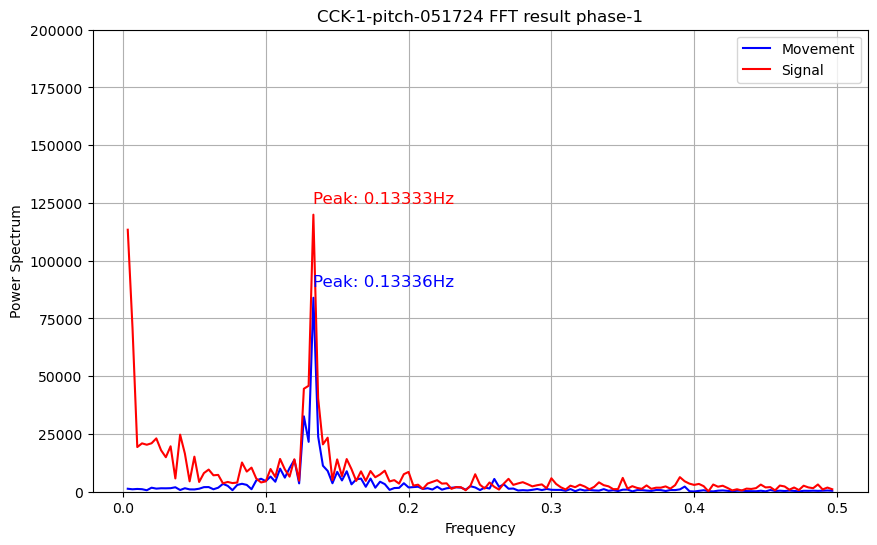

<Figure size 640x480 with 0 Axes>

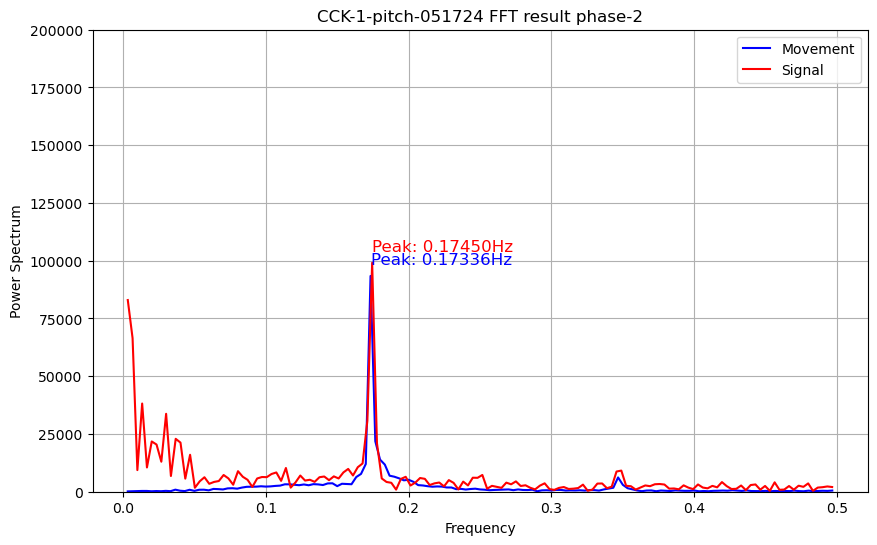

<Figure size 640x480 with 0 Axes>

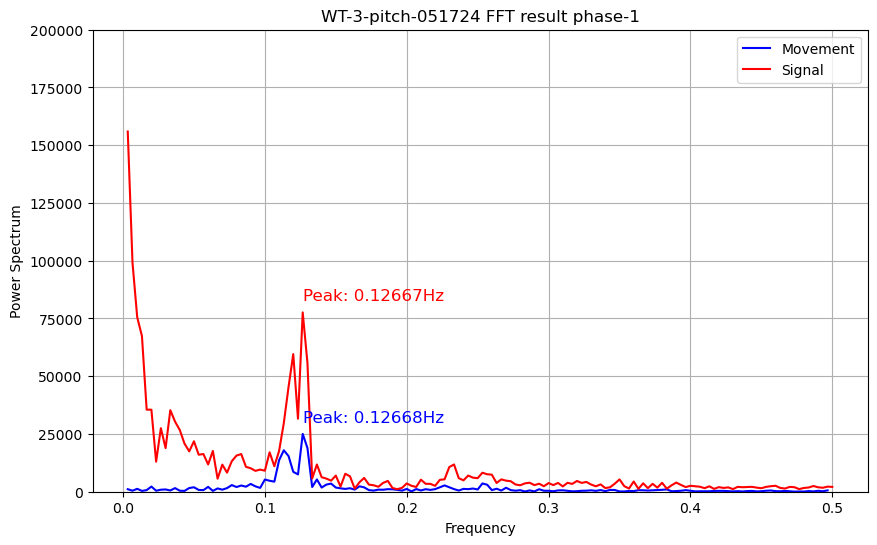

<Figure size 640x480 with 0 Axes>

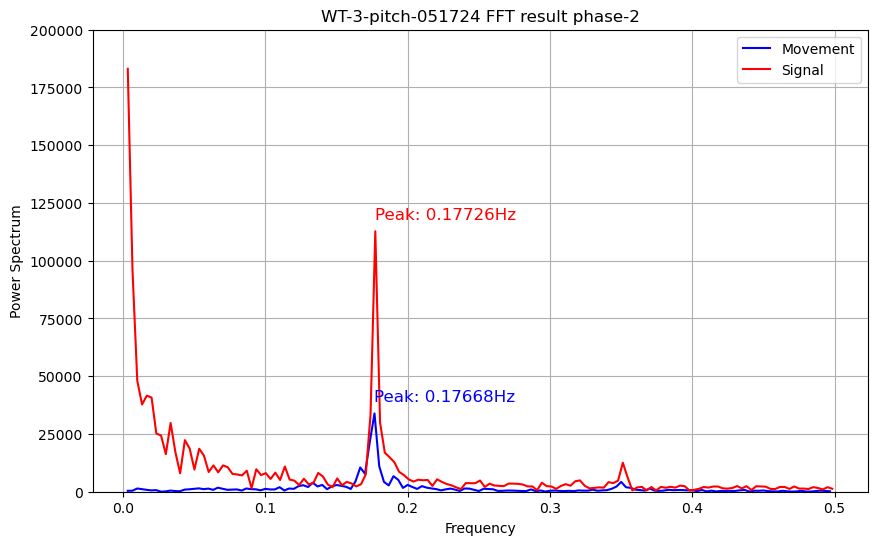

<Figure size 640x480 with 0 Axes>

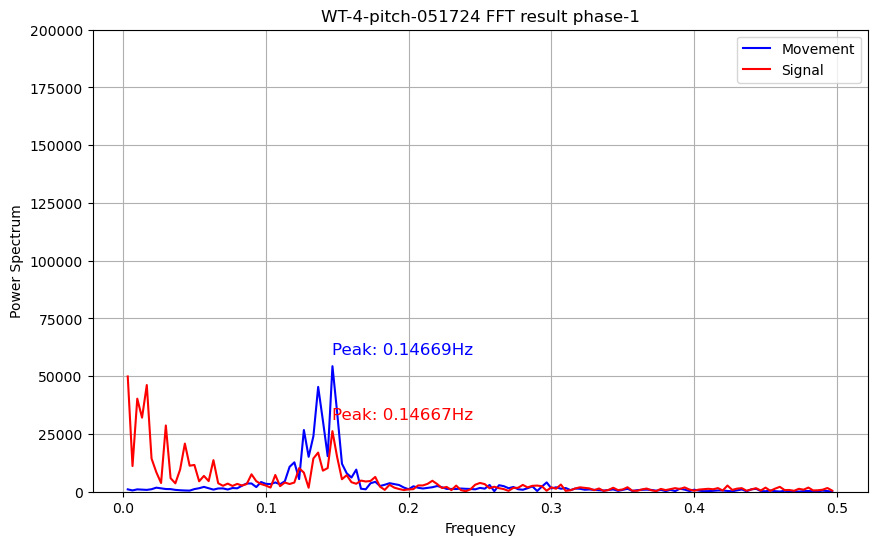

<Figure size 640x480 with 0 Axes>

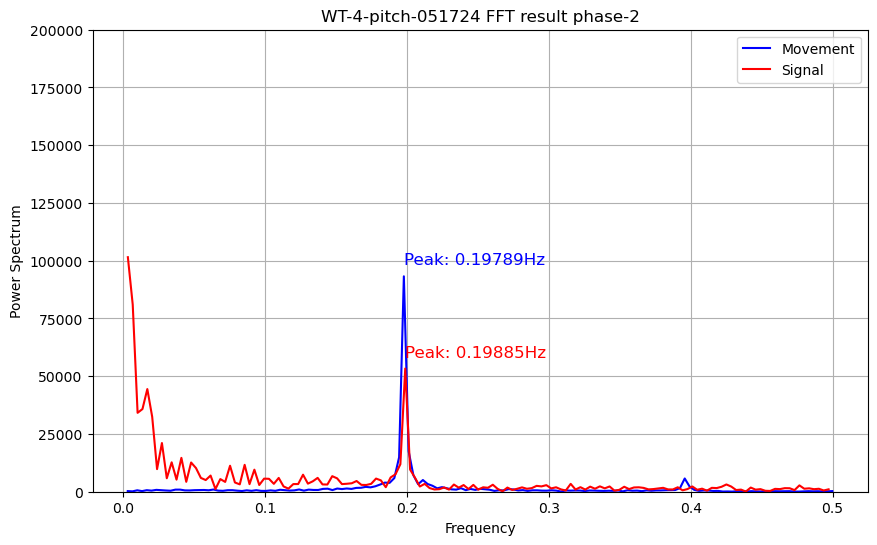

<Figure size 640x480 with 0 Axes>

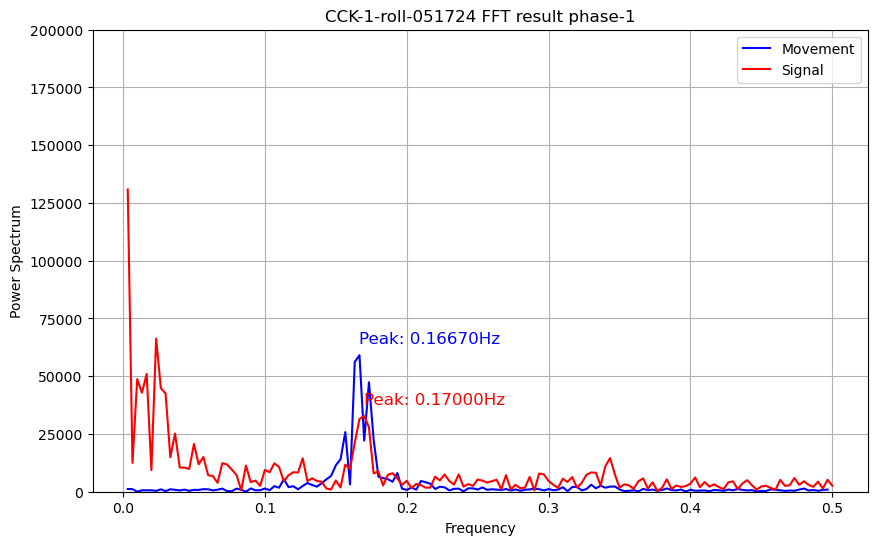

<Figure size 640x480 with 0 Axes>

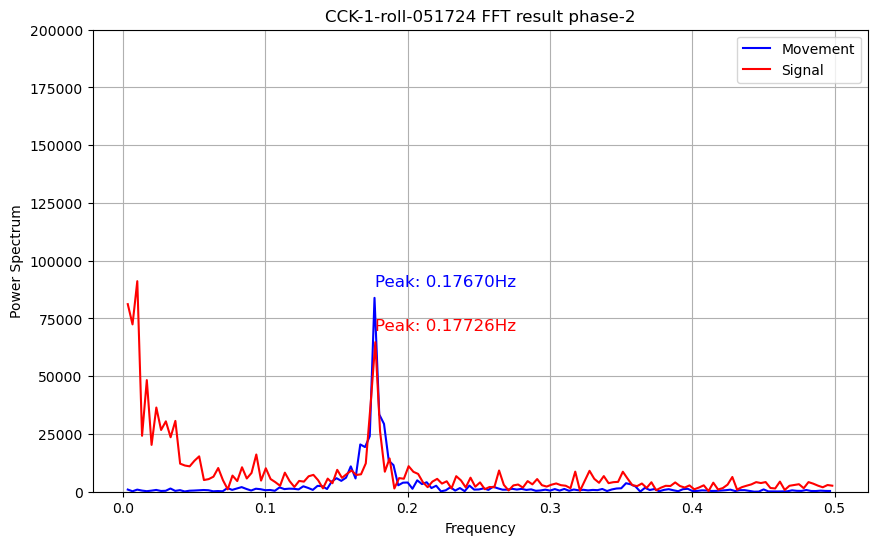

<Figure size 640x480 with 0 Axes>

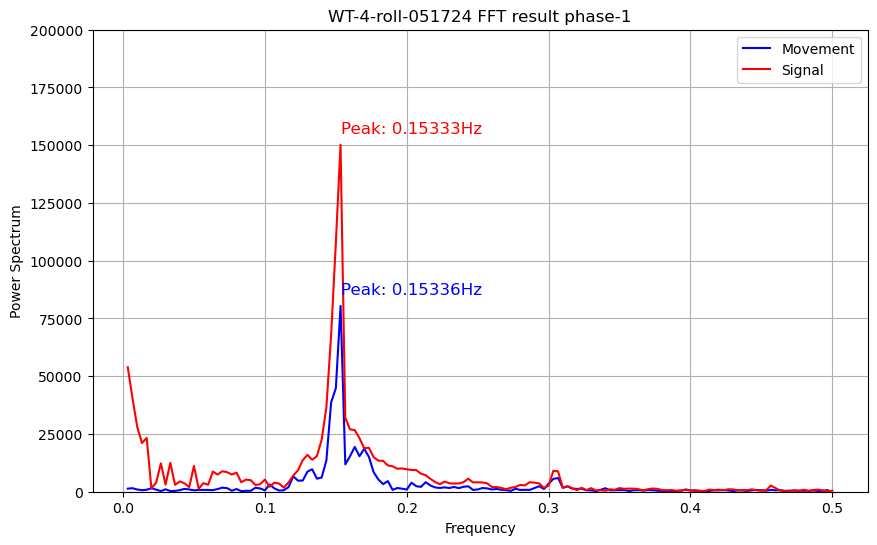

<Figure size 640x480 with 0 Axes>

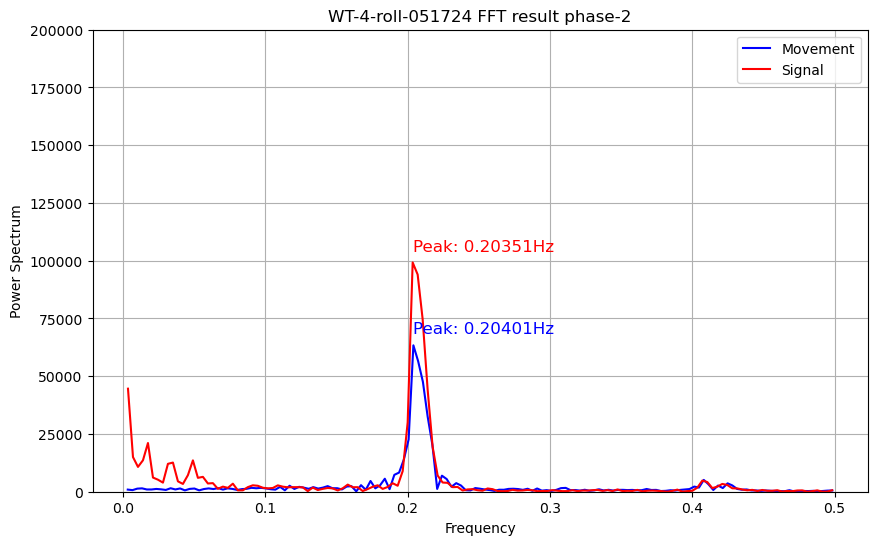

<Figure size 640x480 with 0 Axes>

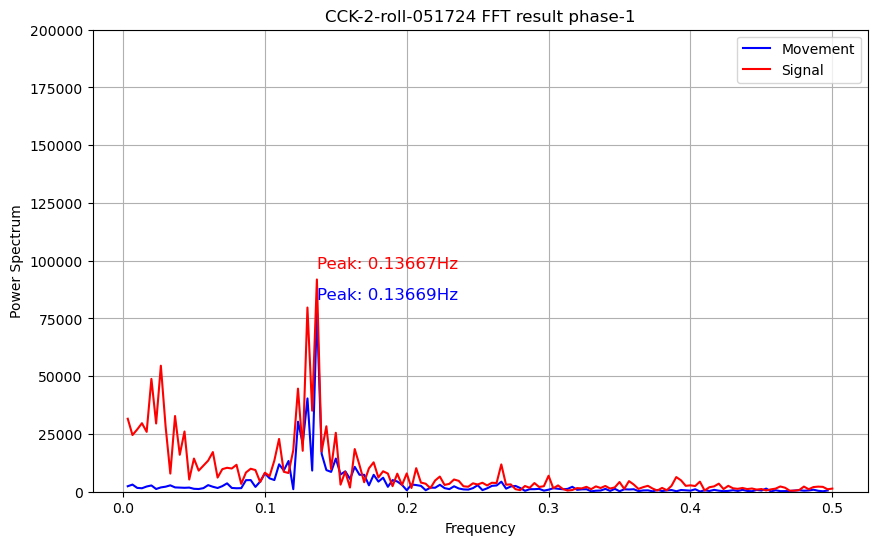

<Figure size 640x480 with 0 Axes>

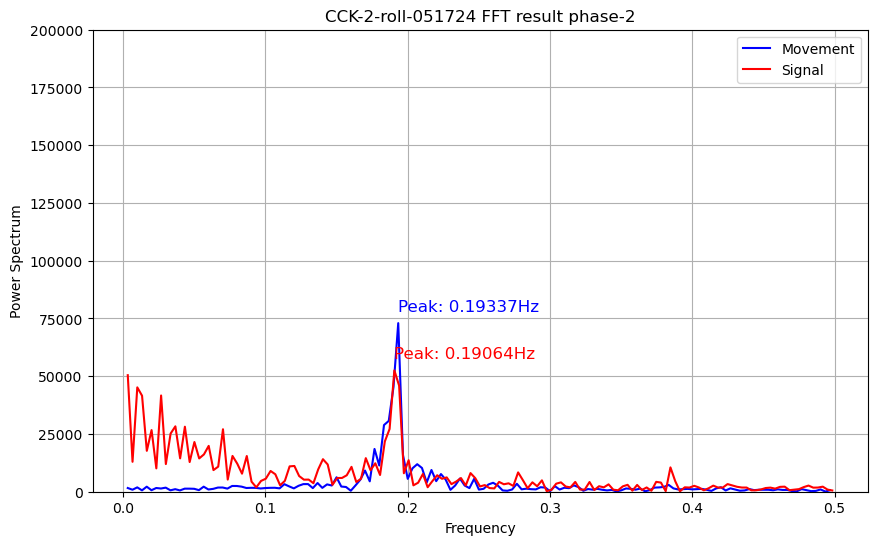

FileNotFoundError: [Errno 2] No such file or directory: '/Users/issacwei/Desktop/LAB/Lee/data/photometry/051724/summary/head movement - phase 1 fft result.csv'

<Figure size 640x480 with 0 Axes>

In [174]:
# fourier plot together
for file in [d for d in glob.glob(folder + '*') if '.DS_Store' and in d or 'summary' not in d]:
    # phase-1
    movement = pd.read_csv(file + '/head movement - phase 1 fft result.csv')
    signal = pd.read_csv(file + '/photometry singal - phase 1 fft result.csv')
    movement = movement[(movement['Frequency'] > 0) & (movement['Frequency'] < 0.5)]
    signal = signal[(signal['Frequency'] > 0) & (signal['Frequency'] < 0.5)]
    movement_peak = movement[(movement['Frequency'] > 0.1) & (movement['Power Spectrum'] == movement[movement['Frequency'] > 0.1]['Power Spectrum'].max())]
    signal_peak = signal[(signal['Frequency'] > 0.1) & (signal['Power Spectrum'] == signal[signal['Frequency'] > 0.1]['Power Spectrum'].max())]

    plt.figure(figsize=(10, 6))
    plt.plot(movement['Frequency'], movement['Power Spectrum'], label='Movement', color='blue')
    plt.text(movement_peak['Frequency'].values[0], movement_peak['Power Spectrum'].values[0]+5000,
             f'Peak: {movement_peak["Frequency"].values[0]:.5f}Hz', 
             color='blue', fontsize=12)

    plt.plot(signal['Frequency'], signal['Power Spectrum'], label='Signal', color='red')
    plt.text(signal_peak['Frequency'].values[0], signal_peak['Power Spectrum'].values[0]+5000,
             f'Peak: {signal_peak["Frequency"].values[0]:.5f}Hz', 
             color='red', fontsize=12)

    plt.ylim(0,200000)
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectrum')
    plt.title(f'{os.path.basename(file)} FFT result phase-1')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file}/FFT result phase-1.png", dpi=300)
    plt.show()
    plt.clf()
    
    # phase-2
    movement = pd.read_csv(file + '/head movement - phase 2 fft result.csv')
    signal = pd.read_csv(file + '/photometry singal - phase 2 fft result.csv')
    movement = movement[(movement['Frequency'] > 0) & (movement['Frequency'] < 0.5)]
    signal = signal[(signal['Frequency'] > 0) & (signal['Frequency'] < 0.5)]
    movement_peak = movement[(movement['Frequency'] > 0.1) & (movement['Power Spectrum'] == movement[movement['Frequency'] > 0.1]['Power Spectrum'].max())]
    signal_peak = signal[(signal['Frequency'] > 0.1) & (signal['Power Spectrum'] == signal[signal['Frequency'] > 0.1]['Power Spectrum'].max())]

    plt.figure(figsize=(10, 6))
    plt.plot(movement['Frequency'], movement['Power Spectrum'], label='Movement', color='blue')
    plt.text(movement_peak['Frequency'].values[0], movement_peak['Power Spectrum'].values[0]+5000,
             f'Peak: {movement_peak["Frequency"].values[0]:.5f}Hz', 
             color='blue', fontsize=12)

    plt.plot(signal['Frequency'], signal['Power Spectrum'], label='Signal', color='red')
    plt.text(signal_peak['Frequency'].values[0], signal_peak['Power Spectrum'].values[0]+5000,
             f'Peak: {signal_peak["Frequency"].values[0]:.5f}Hz', 
             color='red', fontsize=12)

    plt.ylim(0,200000)
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectrum')
    plt.title(f'{os.path.basename(file)} FFT result phase-2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file}/FFT result phase-2.png", dpi=300)
    plt.show()
    plt.clf()

# Sum up results of Fourier analysis

In [171]:
wt_roll = sorted([d for d in glob.glob(folder + '*') if 'WT' in d and 'roll' in d])
wt_pitch = sorted([d for d in glob.glob(folder + '*') if 'WT' in d and 'pitch' in d])
cck_roll = sorted([d for d in glob.glob(folder + '*') if 'CCK' in d and 'roll' in d])
cck_pitch = sorted([d for d in glob.glob(folder + '*') if 'CCK' in d and 'pitch' in d])
sum_list = [wt_roll,wt_pitch,cck_roll,cck_pitch]
sum_name_list = ['WT-roll','WT-pitch','CCK-roll','CCK-pitch']

In [175]:
for i in range(len(sum_list)):
    signal_peak_list = []
    movement_peak_list = []
    for file in sum_list[i]:
        signal_peak = list(pd.read_csv(file+'/photometry dominant freq.csv').iloc[0,:])
        signal_peak_list += signal_peak
        movement_peak = list(pd.read_csv(file+'/head movement dominant freq.csv').iloc[0,:])
        movement_peak_list += movement_peak
    signal_peak_array = np.array(signal_peak_list)
    movement_peak_array = np.array(movement_peak_list)
    correlation_coefficient = np.corrcoef(signal_peak_array, movement_peak_array)[0, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(signal_peak_array, movement_peak_array)
    r_squared = r_value**2    
    plt.plot([min(signal_peak_array),max(signal_peak_array)],[slope * min(signal_peak_array) + intercept, slope * max(signal_peak_array) + intercept], color='red', label=f'Linear fit: y={slope:.2f}x+{intercept:.2f}', linewidth = '1', linestyle = '--')
    plt.scatter(signal_peak_array,movement_peak_array, color = 'black')
    plt.title(f'{sum_name_list[i]} correlation')
    plt.xlabel('Photometry signal peak freq (Hz)')
    plt.ylabel('Head movement peak freq (Hz)')
    plt.text(0.05, 0.90, f'$R^2$ = {r_squared:.5f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.05, 0.85, f'Slope = {slope:.5f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.savefig(folder + f'summary/{sum_name_list[i]} correlation.png',dpi = 300)
    plt.clf()

<Figure size 640x480 with 0 Axes>

# Set a low pass filter to the dataset

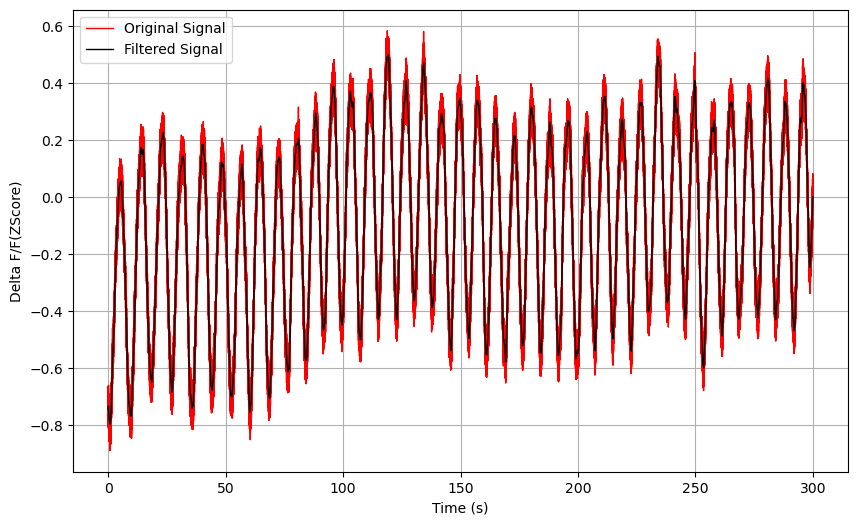

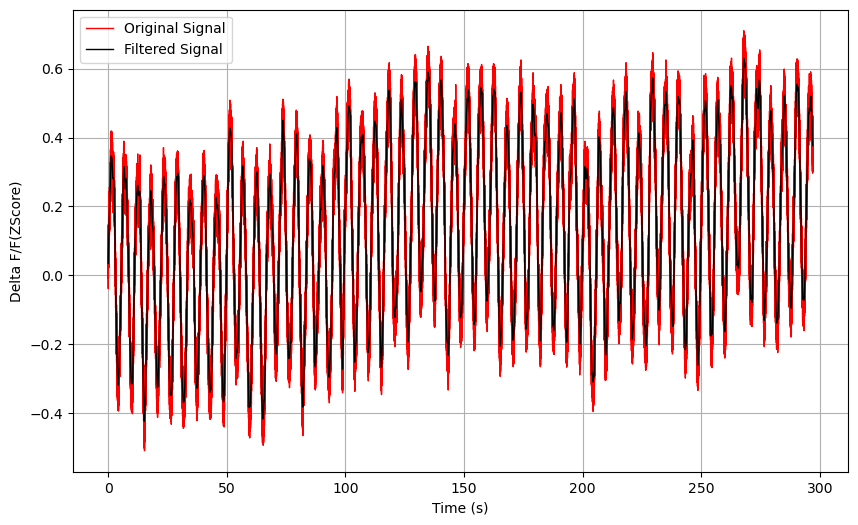

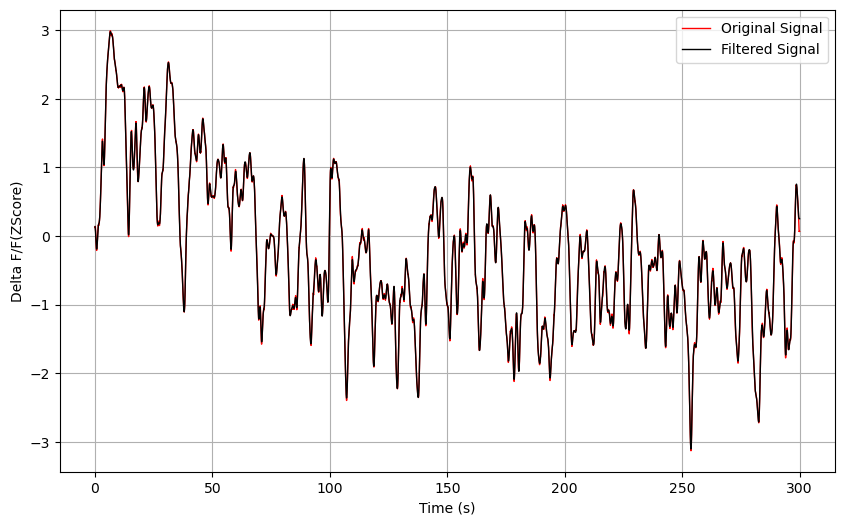

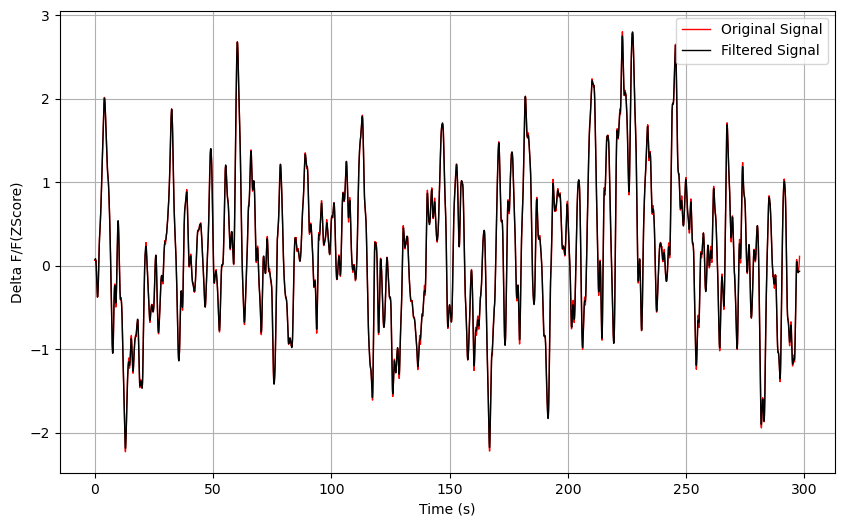

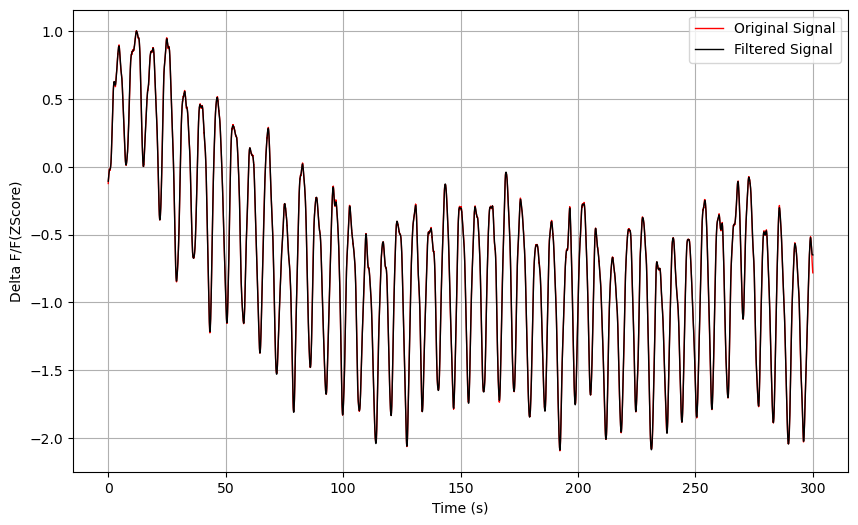

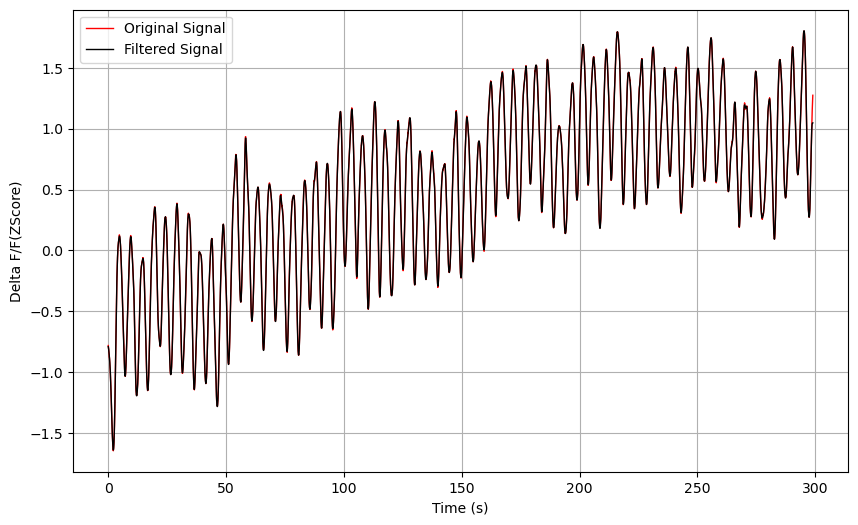

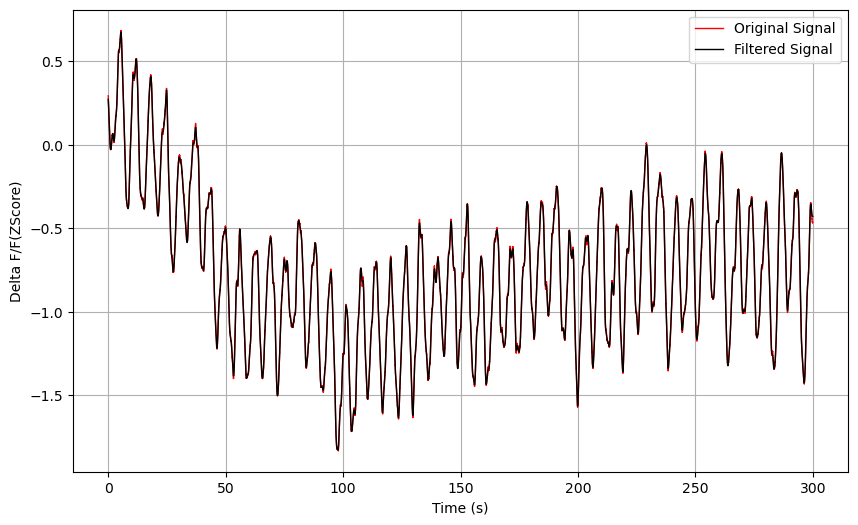

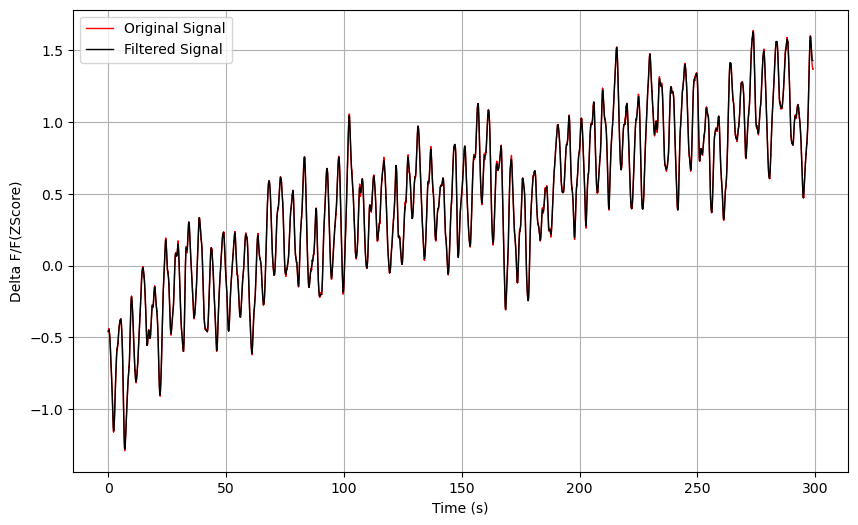

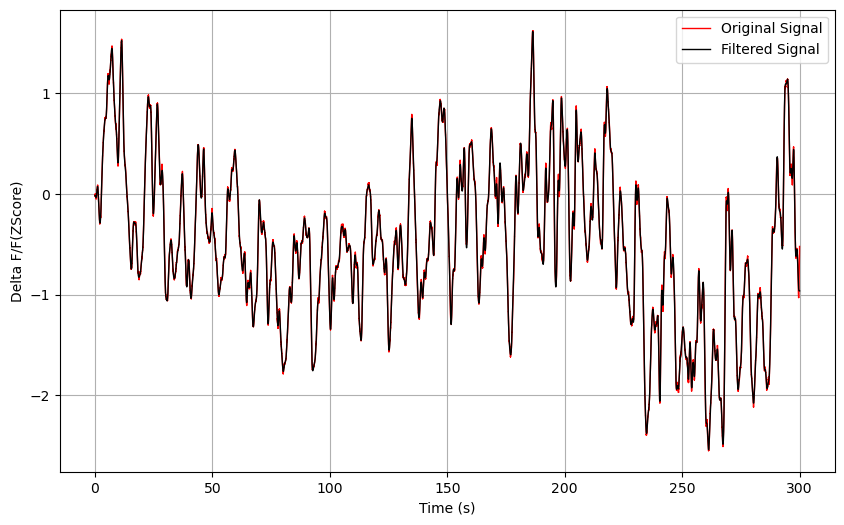

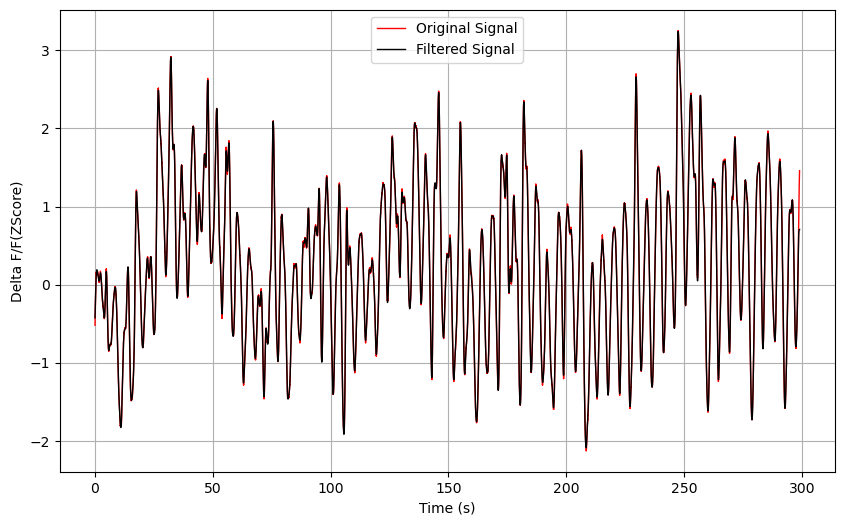

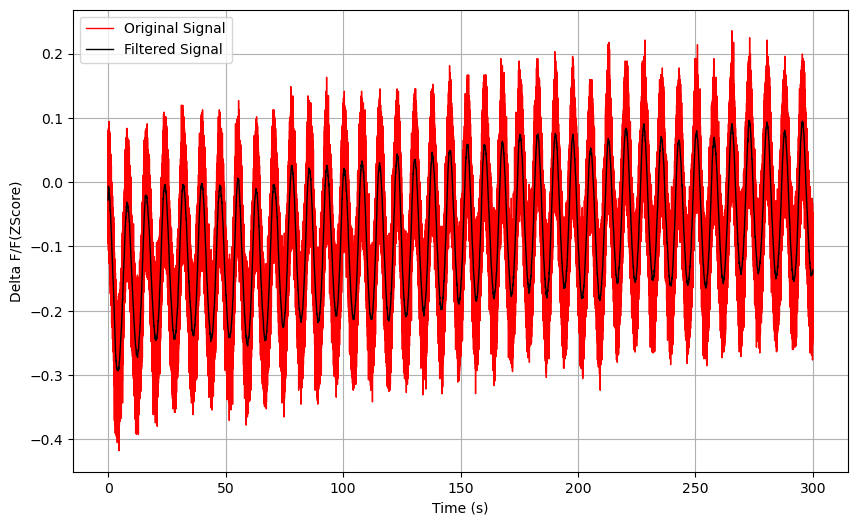

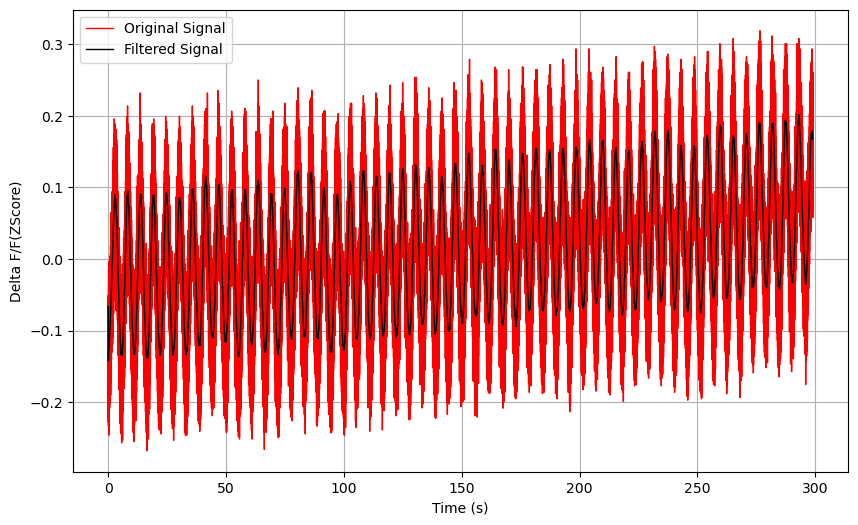

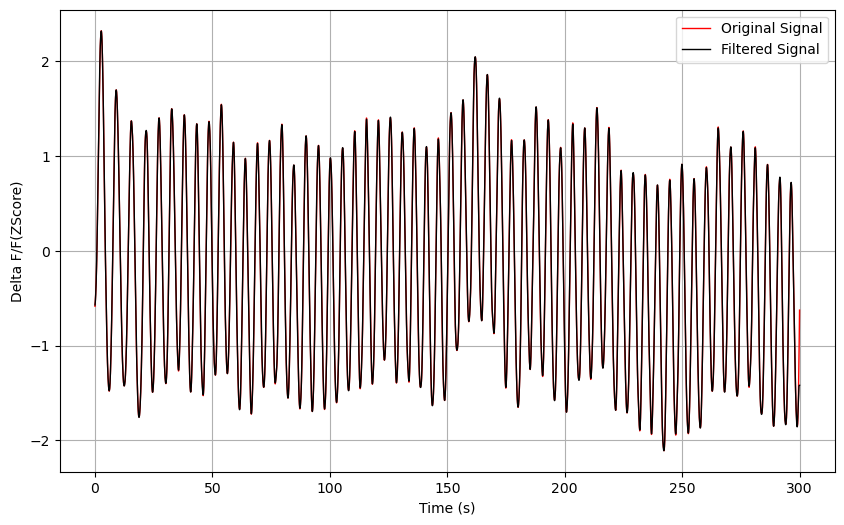

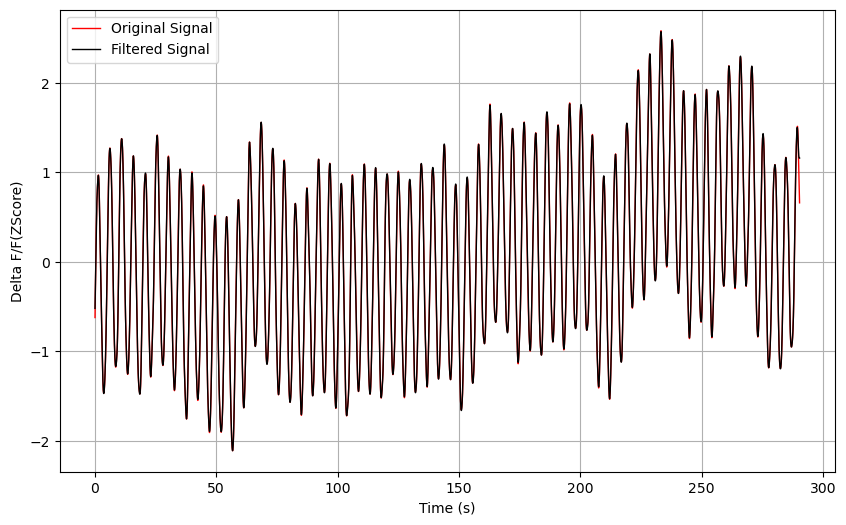

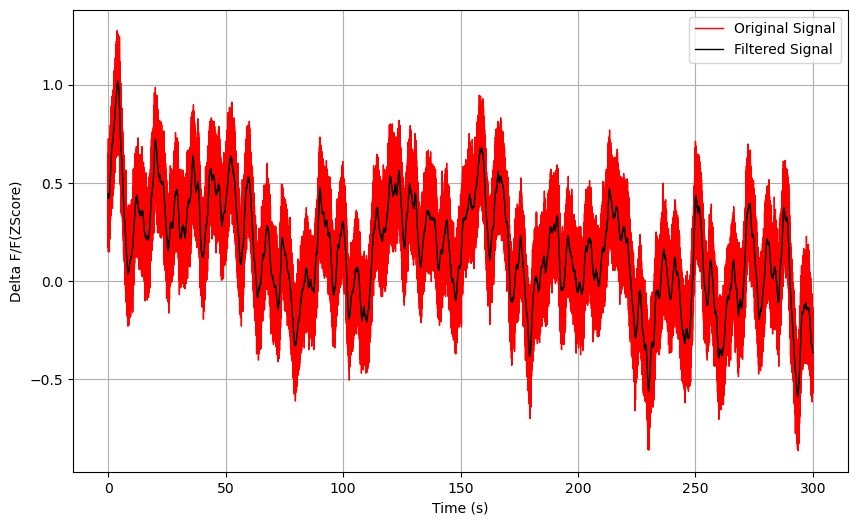

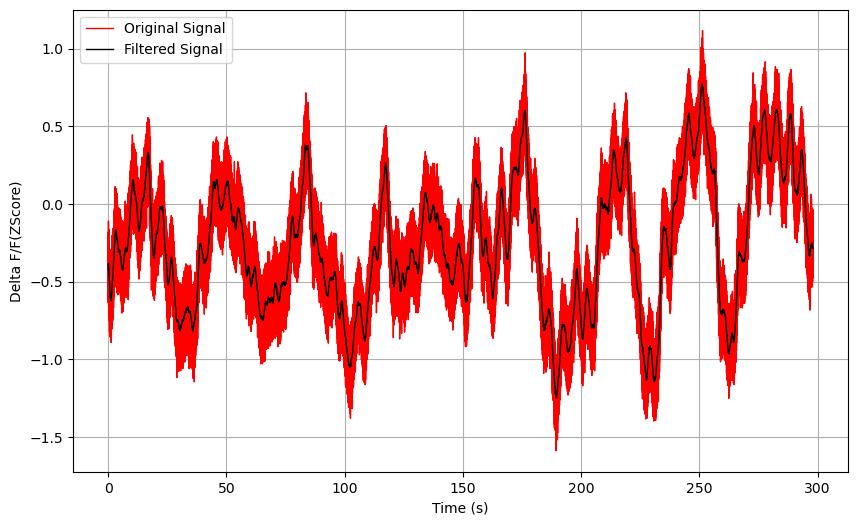

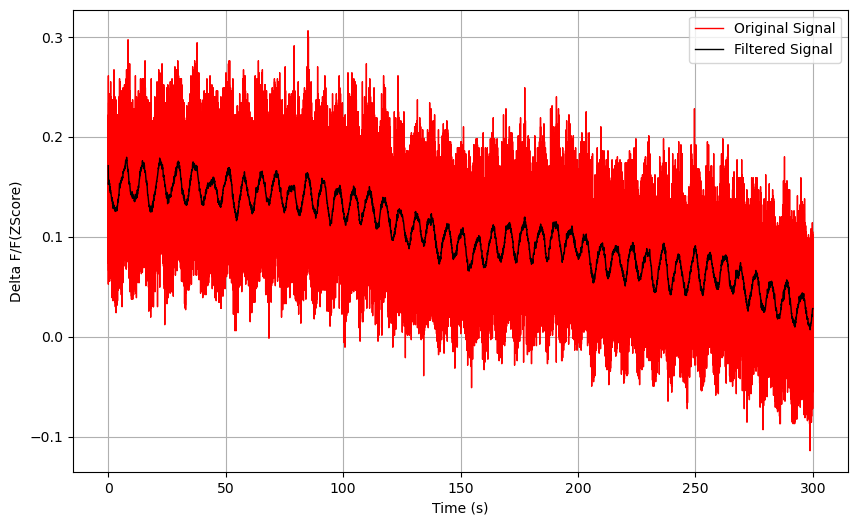

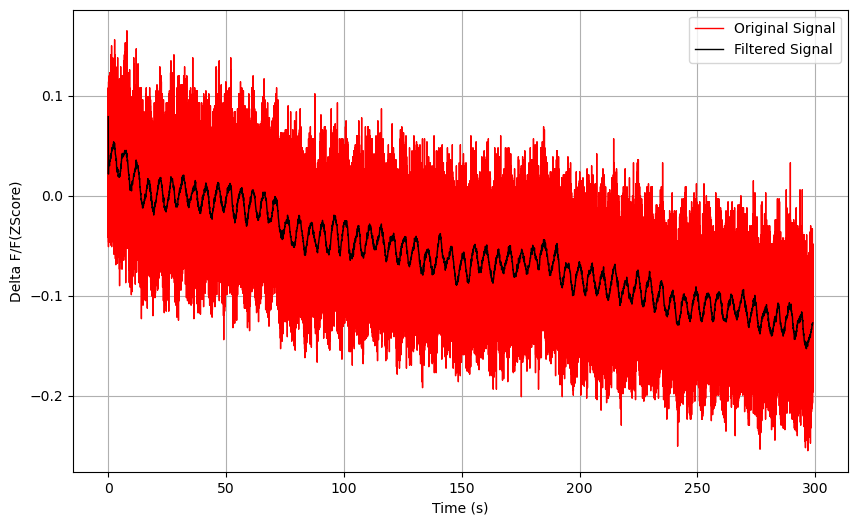

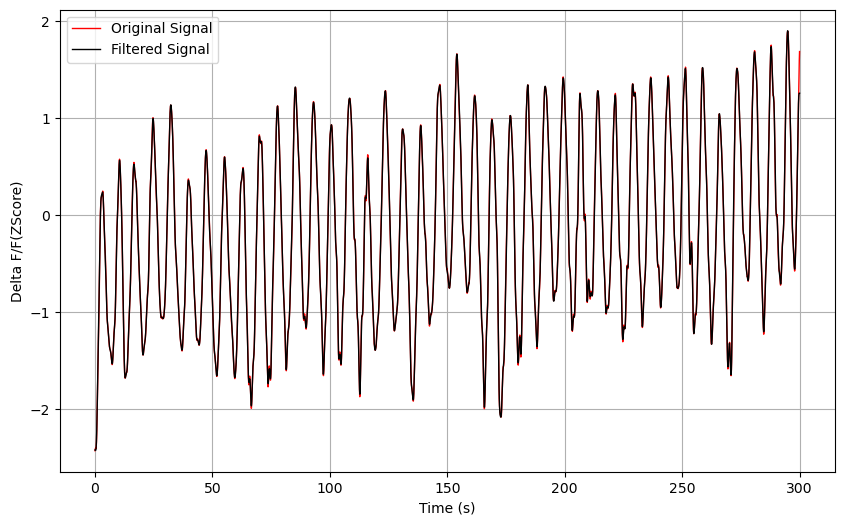

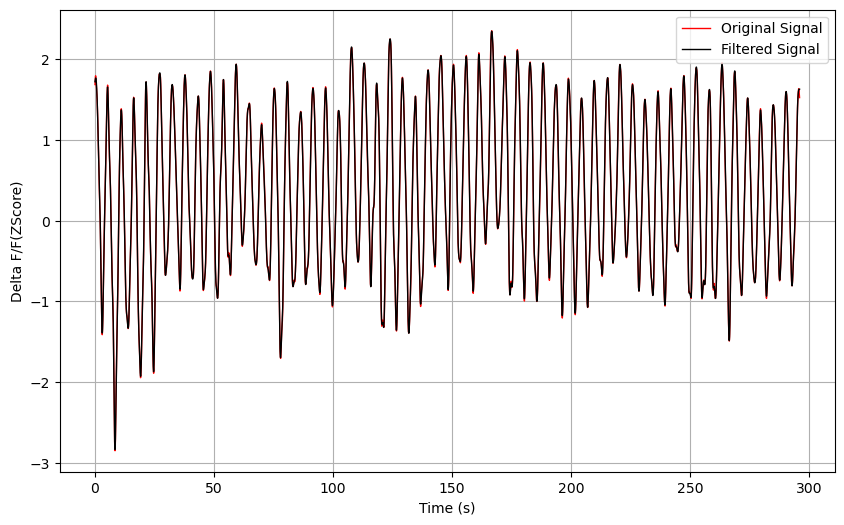

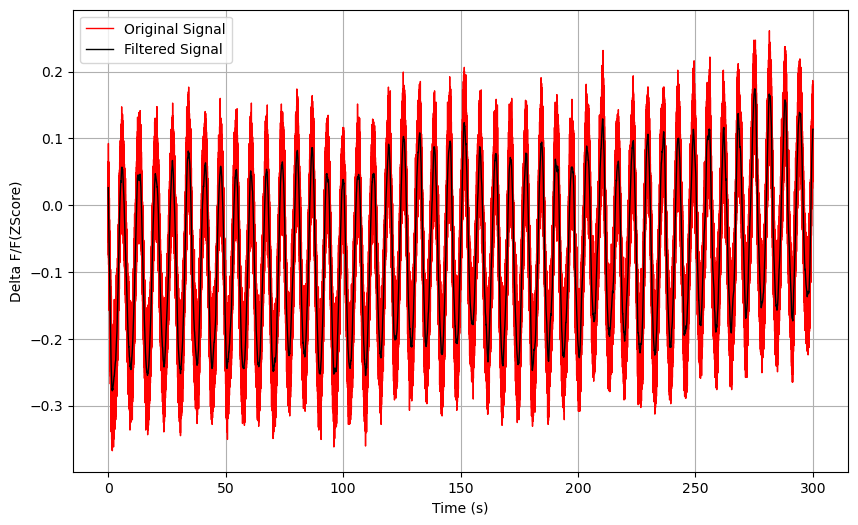

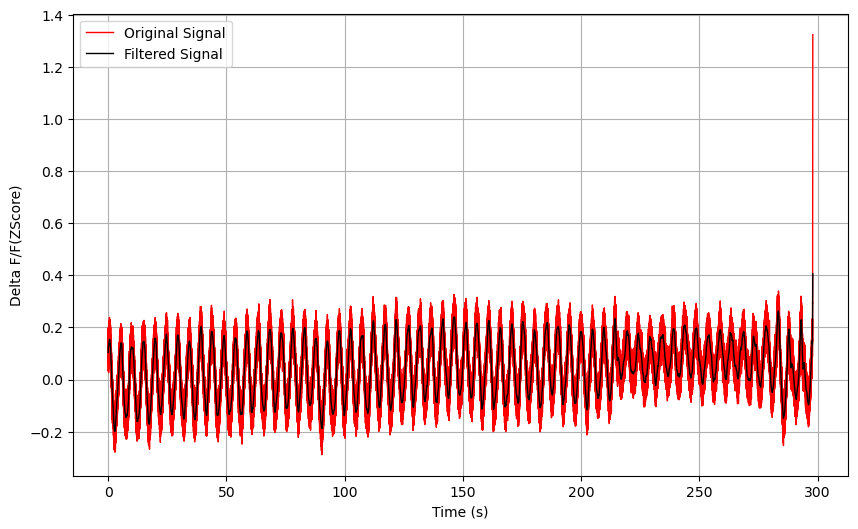

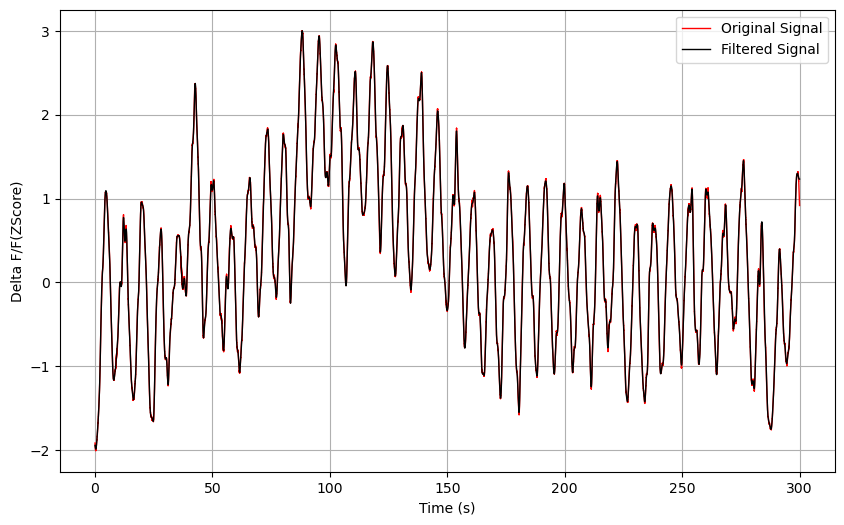

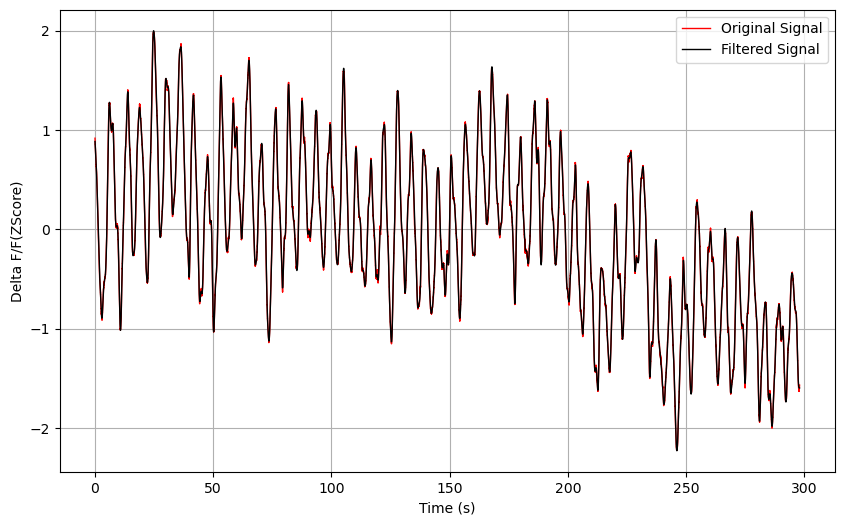

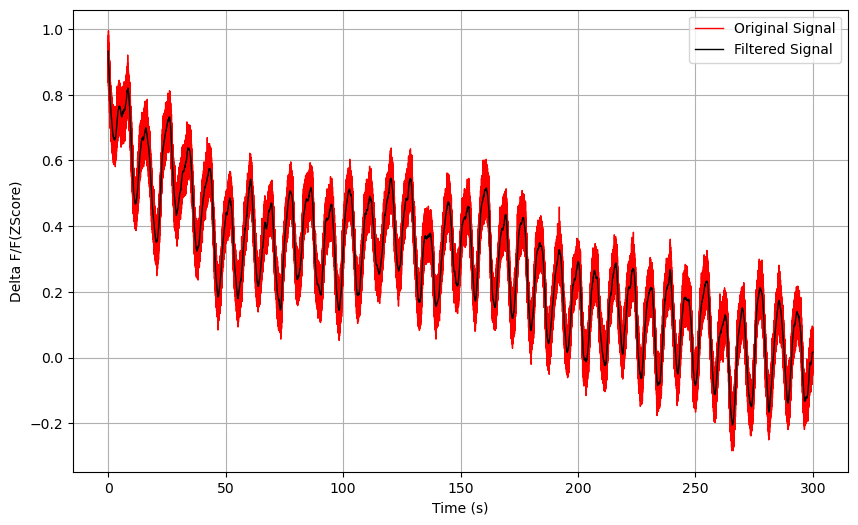

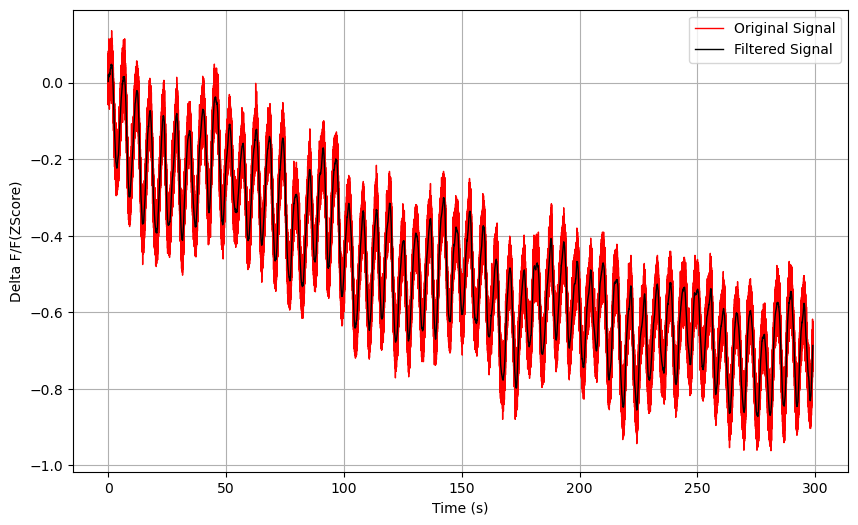

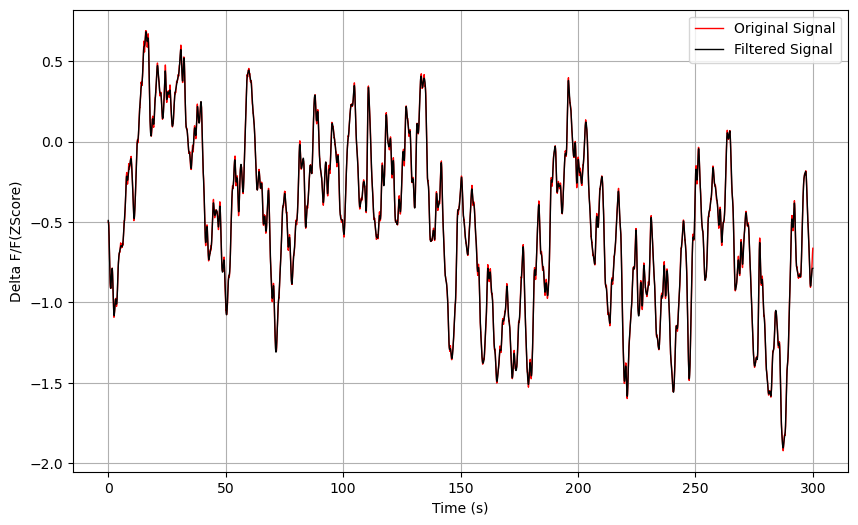

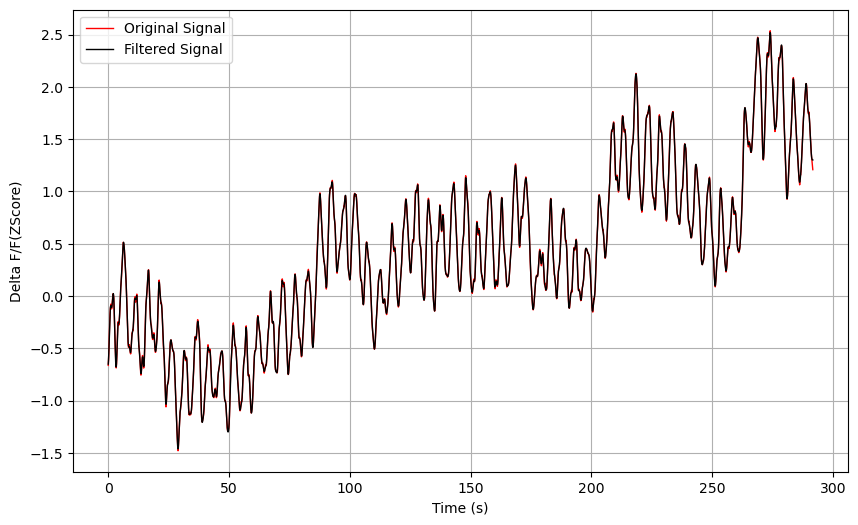

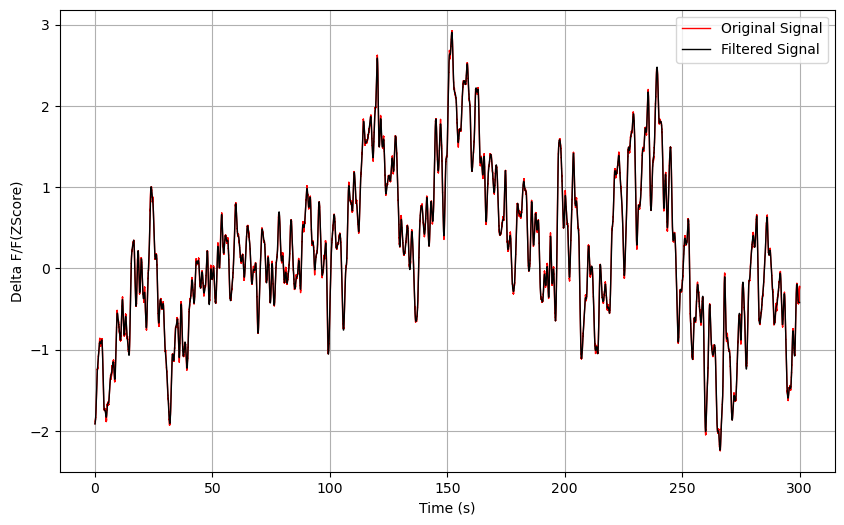

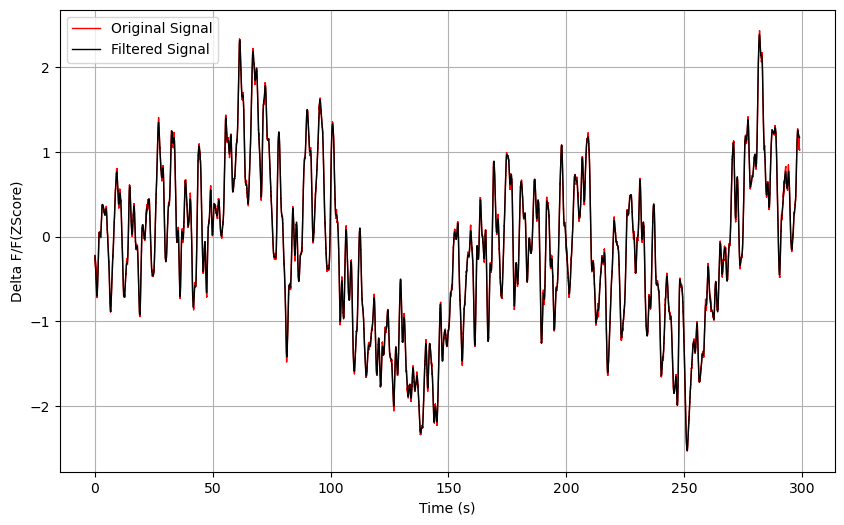

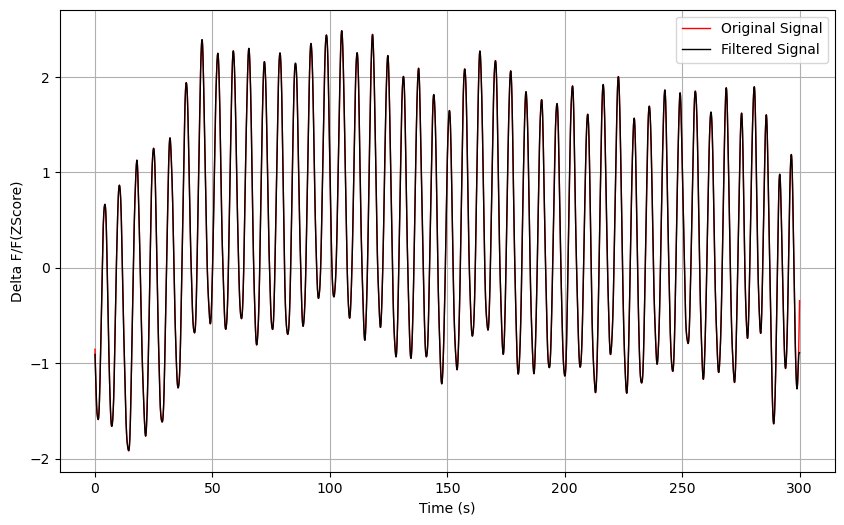

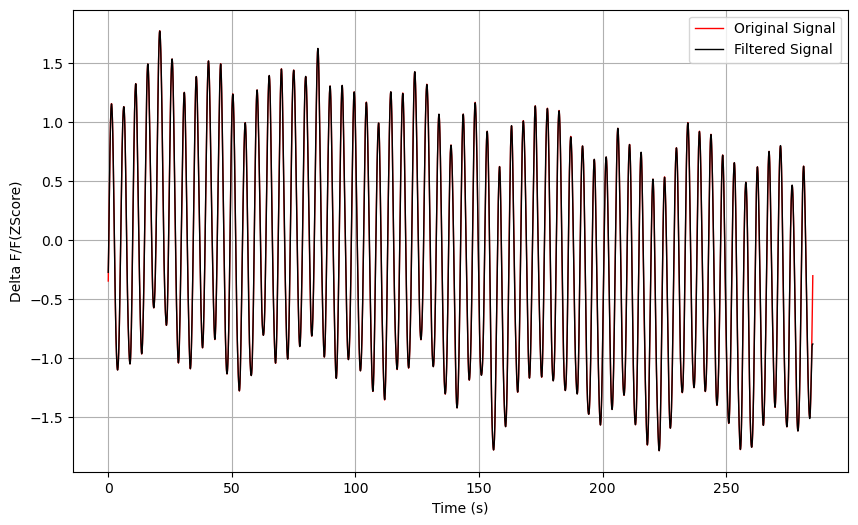

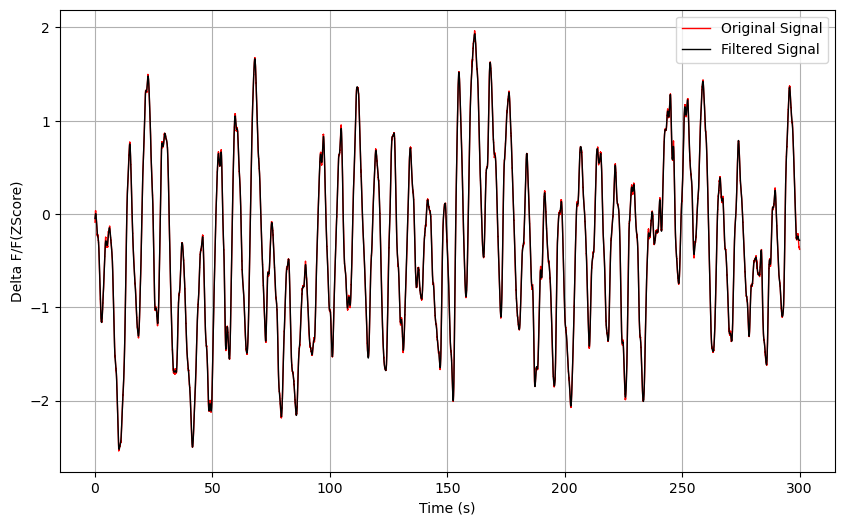

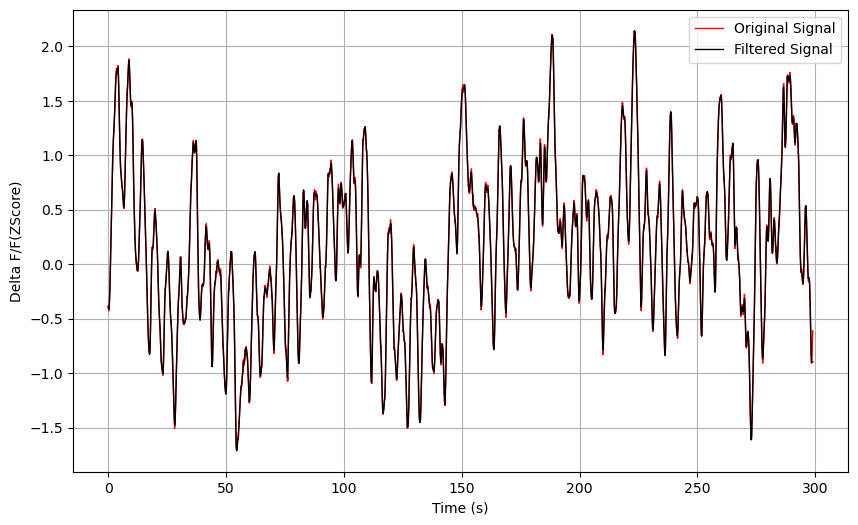

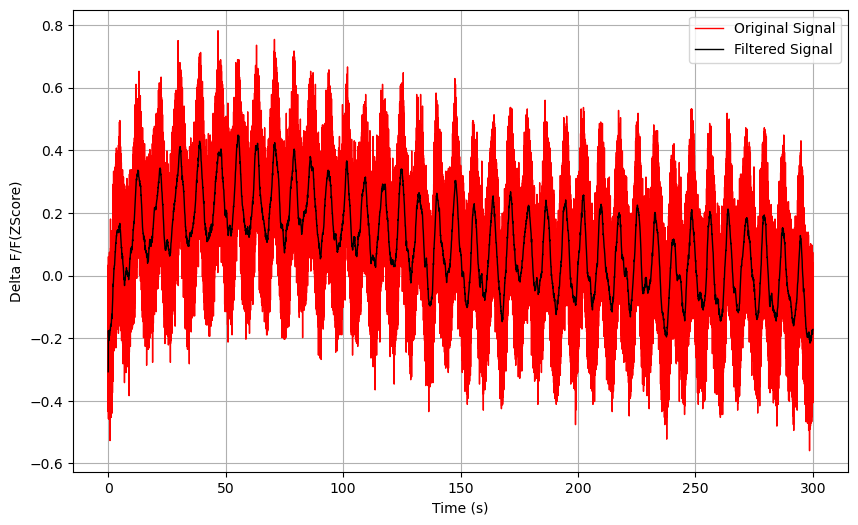

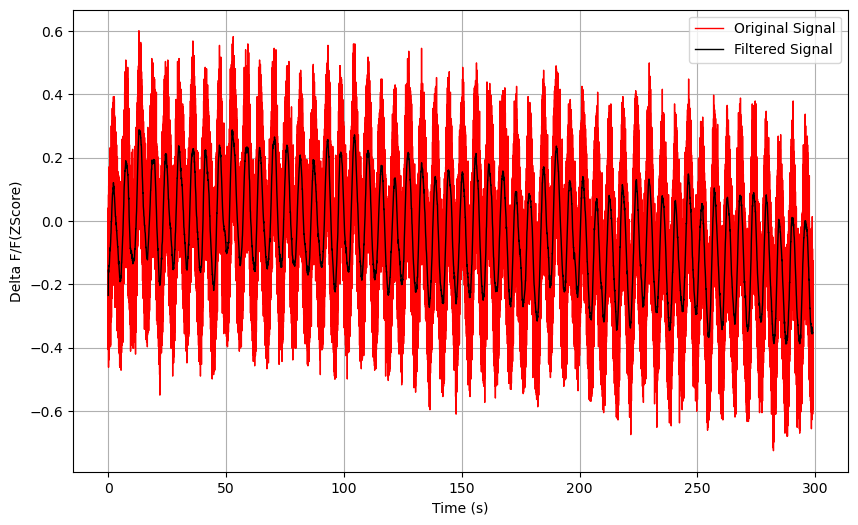

In [247]:
for item in [d for d in glob.glob(folder + '*') if '.DS_Store' not in d and 'summary' not in d]:
    filter_signal(item + '/photometry signal - phase 1.csv')
    filter_signal(item + '/photometry signal - phase 2.csv')

# Phase locking analysis and Plot the motion and photometry signal together

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

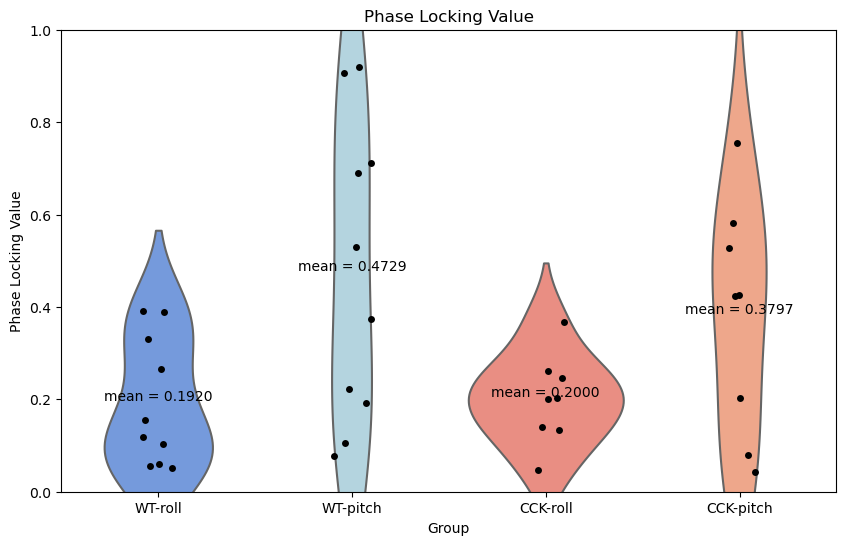

In [248]:
phase_lock_angle_df = pd.DataFrame()
for i in range(len(sum_list)):
    plv_list = []
    for file in sum_list[i]:
        fp_1 = pd.read_csv(file+'/photometry signal - phase 1.csv')
        fp_1['Time'] -= fp_1['Time'][0]
        fp_2 = pd.read_csv(file+'/photometry signal - phase 2.csv')
        fp_2['Time'] -= fp_2['Time'][0]
        hm = pd.read_csv(file+'/coords.csv')
        hm = hm[(hm['X']>250) & (hm['X']<390)]
        hm_1 = hm[(hm['Time']>60)&(hm['Time']<360)]
        hm_1['Time'] -= 60
        hm_2 = hm[(hm['Time']>360)&(hm['Time']<660)]
        hm_2['Time'] -= 360
        
        # Phase locking analysis
        plv_list.append(phase_lock_angle(fp_1,hm_1))
        plv_list.append(phase_lock_angle(fp_2,hm_2)) 
        
        # Plotting 
        combine_plot(file,fp_1,hm_1,'phase 1')
        combine_plot(file,fp_2,hm_2,'phase 2')
        
    phase_lock_angle_df[sum_name_list[i]] = pd.Series(plv_list)
phase_lock_angle_df.to_csv(folder + 'summary/phase locking value.csv',index=False)

# Phase locking analysis plotting
df_melted = phase_lock_angle_df.melt(var_name='Group', value_name='Phase Locking Value')
plt.figure(figsize=(10, 6))
colors = ['cornflowerblue', 'lightblue', 'salmon', 'lightsalmon']
sns.violinplot(x='Group', y='Phase Locking Value', data=df_melted, inner=None, palette=colors)
sns.stripplot(x='Group', y='Phase Locking Value', data=df_melted, jitter=True, color='black')
for i, group in enumerate(phase_lock_angle_df.columns):
    mean_value = phase_lock_angle_df[group].mean()
    plt.text(i, mean_value, f'mean = {mean_value:.4f}', ha='center', va='bottom', color='black')
plt.ylabel('Phase Locking Value')
plt.title('Phase Locking Value')
plt.ylim(0, 1.0)
plt.savefig(folder + '/summary/phase locking value violin plot.png',dpi = 300)

# Analysis the peak with the motion (phase angle)

In [ ]:
fp_1 = pd.read_csv(file+'/photometry signal - phase 1.csv')